In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 832)
(2867343, 8)
validation
(519557, 832)
(519557, 8)
test
(237229, 832)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/287 [..............................] - ETA: 6:21 - loss: 2.4465 - STD: 0.1175 - MAE: 0.2144

  5/287 [..............................] - ETA: 4s - loss: 2.1753 - STD: 0.0579 - MAE: 0.2164  

  9/287 [..............................] - ETA: 4s - loss: 2.1431 - STD: 0.0505 - MAE: 0.2169

 13/287 [>.............................] - ETA: 4s - loss: 2.1191 - STD: 0.0473 - MAE: 0.2168

 17/287 [>.............................] - ETA: 4s - loss: 2.1043 - STD: 0.0449 - MAE: 0.2167

 21/287 [=>............................] - ETA: 4s - loss: 2.0958 - STD: 0.0434 - MAE: 0.2167

 25/287 [=>............................] - ETA: 4s - loss: 2.0890 - STD: 0.0424 - MAE: 0.2167

 29/287 [==>...........................] - ETA: 4s - loss: 2.0834 - STD: 0.0407 - MAE: 0.2167

 33/287 [==>...........................] - ETA: 4s - loss: 2.0788 - STD: 0.0397 - MAE: 0.2166

 36/287 [==>...........................] - ETA: 3s - loss: 2.0757 - STD: 0.0392 - MAE: 0.2166

 40/287 [===>..........................] - ETA: 3s - loss: 2.0714 - STD: 0.0384 - MAE: 0.2165

 44/287 [===>..........................] - ETA: 3s - loss: 2.0666 - STD: 0.0381 - MAE: 0.2164

 48/287 [====>.........................] - ETA: 3s - loss: 2.0607 - STD: 0.0381 - MAE: 0.2162

 52/287 [====>.........................] - ETA: 3s - loss: 2.0535 - STD: 0.0384 - MAE: 0.2160

 56/287 [====>.........................] - ETA: 3s - loss: 2.0450 - STD: 0.0396 - MAE: 0.2155

 60/287 [=====>........................] - ETA: 3s - loss: 2.0358 - STD: 0.0414 - MAE: 0.2150

 64/287 [=====>........................] - ETA: 3s - loss: 2.0262 - STD: 0.0432 - MAE: 0.2145

 68/287 [======>.......................] - ETA: 3s - loss: 2.0155 - STD: 0.0450 - MAE: 0.2139

 72/287 [======>.......................] - ETA: 3s - loss: 2.0041 - STD: 0.0469 - MAE: 0.2133

 76/287 [======>.......................] - ETA: 3s - loss: 1.9914 - STD: 0.0488 - MAE: 0.2126

 80/287 [=======>......................] - ETA: 3s - loss: 1.9776 - STD: 0.0508 - MAE: 0.2119

 84/287 [=======>......................] - ETA: 3s - loss: 1.9620 - STD: 0.0531 - MAE: 0.2111

 88/287 [========>.....................] - ETA: 3s - loss: 1.9454 - STD: 0.0556 - MAE: 0.2101

 92/287 [========>.....................] - ETA: 3s - loss: 1.9290 - STD: 0.0582 - MAE: 0.2091

 96/287 [=========>....................] - ETA: 3s - loss: 1.9125 - STD: 0.0609 - MAE: 0.2081

100/287 [=========>....................] - ETA: 2s - loss: 1.8967 - STD: 0.0635 - MAE: 0.2071

104/287 [=========>....................] - ETA: 2s - loss: 1.8815 - STD: 0.0661 - MAE: 0.2062

108/287 [==========>...................] - ETA: 2s - loss: 1.8670 - STD: 0.0685 - MAE: 0.2052

112/287 [==========>...................] - ETA: 2s - loss: 1.8528 - STD: 0.0707 - MAE: 0.2043

116/287 [===========>..................] - ETA: 2s - loss: 1.8393 - STD: 0.0729 - MAE: 0.2035

120/287 [===========>..................] - ETA: 2s - loss: 1.8259 - STD: 0.0750 - MAE: 0.2026

124/287 [===========>..................] - ETA: 2s - loss: 1.8130 - STD: 0.0771 - MAE: 0.2017

128/287 [============>.................] - ETA: 2s - loss: 1.8007 - STD: 0.0791 - MAE: 0.2008

132/287 [============>.................] - ETA: 2s - loss: 1.7890 - STD: 0.0811 - MAE: 0.2000

136/287 [=============>................] - ETA: 2s - loss: 1.7775 - STD: 0.0830 - MAE: 0.1992

140/287 [=============>................] - ETA: 2s - loss: 1.7665 - STD: 0.0848 - MAE: 0.1984

144/287 [==============>...............] - ETA: 2s - loss: 1.7559 - STD: 0.0867 - MAE: 0.1977

148/287 [==============>...............] - ETA: 2s - loss: 1.7456 - STD: 0.0885 - MAE: 0.1969

152/287 [==============>...............] - ETA: 2s - loss: 1.7357 - STD: 0.0902 - MAE: 0.1962

156/287 [===============>..............] - ETA: 2s - loss: 1.7261 - STD: 0.0918 - MAE: 0.1954

160/287 [===============>..............] - ETA: 2s - loss: 1.7167 - STD: 0.0934 - MAE: 0.1947

164/287 [================>.............] - ETA: 1s - loss: 1.7076 - STD: 0.0950 - MAE: 0.1941

168/287 [================>.............] - ETA: 1s - loss: 1.6989 - STD: 0.0965 - MAE: 0.1934

172/287 [================>.............] - ETA: 1s - loss: 1.6904 - STD: 0.0979 - MAE: 0.1927

176/287 [=================>............] - ETA: 1s - loss: 1.6821 - STD: 0.0993 - MAE: 0.1921

180/287 [=================>............] - ETA: 1s - loss: 1.6744 - STD: 0.1007 - MAE: 0.1915

184/287 [==================>...........] - ETA: 1s - loss: 1.6670 - STD: 0.1020 - MAE: 0.1909

188/287 [==================>...........] - ETA: 1s - loss: 1.6596 - STD: 0.1033 - MAE: 0.1903

191/287 [==================>...........] - ETA: 1s - loss: 1.6541 - STD: 0.1042 - MAE: 0.1899

195/287 [===================>..........] - ETA: 1s - loss: 1.6472 - STD: 0.1055 - MAE: 0.1894

199/287 [===================>..........] - ETA: 1s - loss: 1.6403 - STD: 0.1066 - MAE: 0.1888

203/287 [====================>.........] - ETA: 1s - loss: 1.6334 - STD: 0.1078 - MAE: 0.1883

205/287 [====================>.........] - ETA: 1s - loss: 1.6306 - STD: 0.1084 - MAE: 0.1880

209/287 [====================>.........] - ETA: 1s - loss: 1.6240 - STD: 0.1095 - MAE: 0.1875

213/287 [=====================>........] - ETA: 1s - loss: 1.6177 - STD: 0.1106 - MAE: 0.1870

217/287 [=====================>........] - ETA: 1s - loss: 1.6114 - STD: 0.1117 - MAE: 0.1865

221/287 [======================>.......] - ETA: 1s - loss: 1.6053 - STD: 0.1127 - MAE: 0.1860

225/287 [======================>.......] - ETA: 1s - loss: 1.5994 - STD: 0.1137 - MAE: 0.1855

229/287 [======================>.......] - ETA: 1s - loss: 1.5939 - STD: 0.1147 - MAE: 0.1850

233/287 [=======================>......] - ETA: 1s - loss: 1.5887 - STD: 0.1157 - MAE: 0.1846

237/287 [=======================>......] - ETA: 0s - loss: 1.5835 - STD: 0.1167 - MAE: 0.1841

241/287 [========================>.....] - ETA: 0s - loss: 1.5782 - STD: 0.1176 - MAE: 0.1837

245/287 [========================>.....] - ETA: 0s - loss: 1.5731 - STD: 0.1184 - MAE: 0.1833

249/287 [=========================>....] - ETA: 0s - loss: 1.5681 - STD: 0.1193 - MAE: 0.1829

253/287 [=========================>....] - ETA: 0s - loss: 1.5632 - STD: 0.1202 - MAE: 0.1825

257/287 [=========================>....] - ETA: 0s - loss: 1.5584 - STD: 0.1210 - MAE: 0.1821

261/287 [==========================>...] - ETA: 0s - loss: 1.5536 - STD: 0.1218 - MAE: 0.1817

265/287 [==========================>...] - ETA: 0s - loss: 1.5488 - STD: 0.1226 - MAE: 0.1813

269/287 [===========================>..] - ETA: 0s - loss: 1.5442 - STD: 0.1234 - MAE: 0.1809

273/287 [===========================>..] - ETA: 0s - loss: 1.5396 - STD: 0.1242 - MAE: 0.1805

277/287 [===========================>..] - ETA: 0s - loss: 1.5351 - STD: 0.1249 - MAE: 0.1801

281/287 [============================>.] - ETA: 0s - loss: 1.5308 - STD: 0.1257 - MAE: 0.1798

285/287 [============================>.] - ETA: 0s - loss: 1.5265 - STD: 0.1264 - MAE: 0.1794

287/287 [==============================] - 8s 23ms/step - loss: 1.5244 - STD: 0.1268 - MAE: 0.1792 - val_loss: 1.2722 - val_STD: 0.1725 - val_MAE: 0.1570


Epoch 2/10000


  1/287 [..............................] - ETA: 12s - loss: 1.2188 - STD: 0.1767 - MAE: 0.1535

  5/287 [..............................] - ETA: 4s - loss: 1.2223 - STD: 0.1770 - MAE: 0.1539 

  9/287 [..............................] - ETA: 4s - loss: 1.2245 - STD: 0.1776 - MAE: 0.1538

 13/287 [>.............................] - ETA: 4s - loss: 1.2230 - STD: 0.1783 - MAE: 0.1535

 17/287 [>.............................] - ETA: 4s - loss: 1.2238 - STD: 0.1784 - MAE: 0.1535

 21/287 [=>............................] - ETA: 4s - loss: 1.2199 - STD: 0.1787 - MAE: 0.1533

 25/287 [=>............................] - ETA: 4s - loss: 1.2187 - STD: 0.1789 - MAE: 0.1531

 29/287 [==>...........................] - ETA: 4s - loss: 1.2162 - STD: 0.1791 - MAE: 0.1529

 33/287 [==>...........................] - ETA: 4s - loss: 1.2146 - STD: 0.1793 - MAE: 0.1528

 36/287 [==>...........................] - ETA: 4s - loss: 1.2132 - STD: 0.1794 - MAE: 0.1527

 40/287 [===>..........................] - ETA: 3s - loss: 1.2145 - STD: 0.1797 - MAE: 0.1526

 44/287 [===>..........................] - ETA: 3s - loss: 1.2151 - STD: 0.1798 - MAE: 0.1526

 48/287 [====>.........................] - ETA: 3s - loss: 1.2155 - STD: 0.1799 - MAE: 0.1526

 52/287 [====>.........................] - ETA: 3s - loss: 1.2142 - STD: 0.1800 - MAE: 0.1525

 55/287 [====>.........................] - ETA: 3s - loss: 1.2137 - STD: 0.1801 - MAE: 0.1524

 59/287 [=====>........................] - ETA: 3s - loss: 1.2126 - STD: 0.1803 - MAE: 0.1524

 62/287 [=====>........................] - ETA: 3s - loss: 1.2116 - STD: 0.1803 - MAE: 0.1523

 66/287 [=====>........................] - ETA: 3s - loss: 1.2112 - STD: 0.1804 - MAE: 0.1522

 70/287 [======>.......................] - ETA: 3s - loss: 1.2098 - STD: 0.1805 - MAE: 0.1521

 74/287 [======>.......................] - ETA: 3s - loss: 1.2085 - STD: 0.1806 - MAE: 0.1520

 78/287 [=======>......................] - ETA: 3s - loss: 1.2072 - STD: 0.1808 - MAE: 0.1519

 82/287 [=======>......................] - ETA: 3s - loss: 1.2059 - STD: 0.1809 - MAE: 0.1518

 86/287 [=======>......................] - ETA: 3s - loss: 1.2044 - STD: 0.1811 - MAE: 0.1517

 89/287 [========>.....................] - ETA: 3s - loss: 1.2036 - STD: 0.1812 - MAE: 0.1516

 93/287 [========>.....................] - ETA: 3s - loss: 1.2022 - STD: 0.1813 - MAE: 0.1515

 97/287 [=========>....................] - ETA: 3s - loss: 1.2015 - STD: 0.1815 - MAE: 0.1514

100/287 [=========>....................] - ETA: 2s - loss: 1.2013 - STD: 0.1817 - MAE: 0.1513

103/287 [=========>....................] - ETA: 2s - loss: 1.2009 - STD: 0.1818 - MAE: 0.1512

107/287 [==========>...................] - ETA: 2s - loss: 1.1998 - STD: 0.1819 - MAE: 0.1511

111/287 [==========>...................] - ETA: 2s - loss: 1.1995 - STD: 0.1821 - MAE: 0.1510

115/287 [===========>..................] - ETA: 2s - loss: 1.1987 - STD: 0.1822 - MAE: 0.1510

119/287 [===========>..................] - ETA: 2s - loss: 1.1980 - STD: 0.1823 - MAE: 0.1509

123/287 [===========>..................] - ETA: 2s - loss: 1.1969 - STD: 0.1824 - MAE: 0.1508

127/287 [============>.................] - ETA: 2s - loss: 1.1959 - STD: 0.1825 - MAE: 0.1507

130/287 [============>.................] - ETA: 2s - loss: 1.1950 - STD: 0.1826 - MAE: 0.1506

134/287 [=============>................] - ETA: 2s - loss: 1.1938 - STD: 0.1827 - MAE: 0.1505

138/287 [=============>................] - ETA: 2s - loss: 1.1926 - STD: 0.1828 - MAE: 0.1504

142/287 [=============>................] - ETA: 2s - loss: 1.1914 - STD: 0.1830 - MAE: 0.1503

146/287 [==============>...............] - ETA: 2s - loss: 1.1903 - STD: 0.1831 - MAE: 0.1502

150/287 [==============>...............] - ETA: 2s - loss: 1.1891 - STD: 0.1832 - MAE: 0.1501

154/287 [===============>..............] - ETA: 2s - loss: 1.1881 - STD: 0.1833 - MAE: 0.1500

158/287 [===============>..............] - ETA: 2s - loss: 1.1877 - STD: 0.1835 - MAE: 0.1500

162/287 [===============>..............] - ETA: 1s - loss: 1.1868 - STD: 0.1836 - MAE: 0.1499

166/287 [================>.............] - ETA: 1s - loss: 1.1857 - STD: 0.1837 - MAE: 0.1498

170/287 [================>.............] - ETA: 1s - loss: 1.1848 - STD: 0.1839 - MAE: 0.1497

174/287 [=================>............] - ETA: 1s - loss: 1.1840 - STD: 0.1840 - MAE: 0.1496

178/287 [=================>............] - ETA: 1s - loss: 1.1831 - STD: 0.1841 - MAE: 0.1495

182/287 [==================>...........] - ETA: 1s - loss: 1.1821 - STD: 0.1843 - MAE: 0.1494

186/287 [==================>...........] - ETA: 1s - loss: 1.1811 - STD: 0.1844 - MAE: 0.1493

190/287 [==================>...........] - ETA: 1s - loss: 1.1801 - STD: 0.1845 - MAE: 0.1492

194/287 [===================>..........] - ETA: 1s - loss: 1.1792 - STD: 0.1846 - MAE: 0.1491

198/287 [===================>..........] - ETA: 1s - loss: 1.1789 - STD: 0.1847 - MAE: 0.1491

202/287 [====================>.........] - ETA: 1s - loss: 1.1785 - STD: 0.1849 - MAE: 0.1490

206/287 [====================>.........] - ETA: 1s - loss: 1.1778 - STD: 0.1850 - MAE: 0.1489

210/287 [====================>.........] - ETA: 1s - loss: 1.1774 - STD: 0.1851 - MAE: 0.1489

214/287 [=====================>........] - ETA: 1s - loss: 1.1765 - STD: 0.1852 - MAE: 0.1488

218/287 [=====================>........] - ETA: 1s - loss: 1.1757 - STD: 0.1853 - MAE: 0.1487

222/287 [======================>.......] - ETA: 1s - loss: 1.1748 - STD: 0.1854 - MAE: 0.1486

226/287 [======================>.......] - ETA: 0s - loss: 1.1739 - STD: 0.1855 - MAE: 0.1485

230/287 [=======================>......] - ETA: 0s - loss: 1.1730 - STD: 0.1856 - MAE: 0.1485

234/287 [=======================>......] - ETA: 0s - loss: 1.1722 - STD: 0.1857 - MAE: 0.1484

237/287 [=======================>......] - ETA: 0s - loss: 1.1715 - STD: 0.1858 - MAE: 0.1483

241/287 [========================>.....] - ETA: 0s - loss: 1.1707 - STD: 0.1859 - MAE: 0.1482

245/287 [========================>.....] - ETA: 0s - loss: 1.1700 - STD: 0.1860 - MAE: 0.1482

248/287 [========================>.....] - ETA: 0s - loss: 1.1696 - STD: 0.1861 - MAE: 0.1481

252/287 [=========================>....] - ETA: 0s - loss: 1.1687 - STD: 0.1862 - MAE: 0.1480

256/287 [=========================>....] - ETA: 0s - loss: 1.1678 - STD: 0.1863 - MAE: 0.1479

260/287 [==========================>...] - ETA: 0s - loss: 1.1668 - STD: 0.1865 - MAE: 0.1478

263/287 [==========================>...] - ETA: 0s - loss: 1.1662 - STD: 0.1865 - MAE: 0.1478

267/287 [==========================>...] - ETA: 0s - loss: 1.1653 - STD: 0.1866 - MAE: 0.1477

271/287 [===========================>..] - ETA: 0s - loss: 1.1644 - STD: 0.1868 - MAE: 0.1476

275/287 [===========================>..] - ETA: 0s - loss: 1.1636 - STD: 0.1869 - MAE: 0.1475

279/287 [============================>.] - ETA: 0s - loss: 1.1626 - STD: 0.1870 - MAE: 0.1474

283/287 [============================>.] - ETA: 0s - loss: 1.1619 - STD: 0.1871 - MAE: 0.1473

287/287 [==============================] - ETA: 0s - loss: 1.1613 - STD: 0.1872 - MAE: 0.1472

287/287 [==============================] - 5s 18ms/step - loss: 1.1613 - STD: 0.1872 - MAE: 0.1472 - val_loss: 1.2278 - val_STD: 0.1906 - val_MAE: 0.1485


Epoch 3/10000


  1/287 [..............................] - ETA: 12s - loss: 1.1007 - STD: 0.1938 - MAE: 0.1416

  5/287 [..............................] - ETA: 4s - loss: 1.1094 - STD: 0.1955 - MAE: 0.1415 

  9/287 [..............................] - ETA: 4s - loss: 1.1125 - STD: 0.1959 - MAE: 0.1416

 12/287 [>.............................] - ETA: 4s - loss: 1.1107 - STD: 0.1959 - MAE: 0.1415

 16/287 [>.............................] - ETA: 4s - loss: 1.1111 - STD: 0.1957 - MAE: 0.1416

 20/287 [=>............................] - ETA: 4s - loss: 1.1090 - STD: 0.1956 - MAE: 0.1415

 24/287 [=>............................] - ETA: 4s - loss: 1.1079 - STD: 0.1956 - MAE: 0.1414

 28/287 [=>............................] - ETA: 4s - loss: 1.1089 - STD: 0.1958 - MAE: 0.1414

 31/287 [==>...........................] - ETA: 4s - loss: 1.1086 - STD: 0.1959 - MAE: 0.1413

 35/287 [==>...........................] - ETA: 4s - loss: 1.1076 - STD: 0.1959 - MAE: 0.1412

 39/287 [===>..........................] - ETA: 4s - loss: 1.1074 - STD: 0.1959 - MAE: 0.1413

 43/287 [===>..........................] - ETA: 3s - loss: 1.1057 - STD: 0.1959 - MAE: 0.1411

 47/287 [===>..........................] - ETA: 3s - loss: 1.1063 - STD: 0.1959 - MAE: 0.1412

 51/287 [====>.........................] - ETA: 3s - loss: 1.1055 - STD: 0.1959 - MAE: 0.1411

 54/287 [====>.........................] - ETA: 3s - loss: 1.1045 - STD: 0.1959 - MAE: 0.1411

 58/287 [=====>........................] - ETA: 3s - loss: 1.1038 - STD: 0.1960 - MAE: 0.1410

 62/287 [=====>........................] - ETA: 3s - loss: 1.1022 - STD: 0.1961 - MAE: 0.1409

 66/287 [=====>........................] - ETA: 3s - loss: 1.1005 - STD: 0.1962 - MAE: 0.1408

 70/287 [======>.......................] - ETA: 3s - loss: 1.0992 - STD: 0.1962 - MAE: 0.1407

 74/287 [======>.......................] - ETA: 3s - loss: 1.0982 - STD: 0.1963 - MAE: 0.1406

 77/287 [=======>......................] - ETA: 3s - loss: 1.0975 - STD: 0.1963 - MAE: 0.1406

 81/287 [=======>......................] - ETA: 3s - loss: 1.0966 - STD: 0.1965 - MAE: 0.1405

 85/287 [=======>......................] - ETA: 3s - loss: 1.0970 - STD: 0.1966 - MAE: 0.1405

 89/287 [========>.....................] - ETA: 3s - loss: 1.0971 - STD: 0.1966 - MAE: 0.1404

 92/287 [========>.....................] - ETA: 3s - loss: 1.0974 - STD: 0.1967 - MAE: 0.1404

 95/287 [========>.....................] - ETA: 3s - loss: 1.0981 - STD: 0.1968 - MAE: 0.1404

 98/287 [=========>....................] - ETA: 3s - loss: 1.0979 - STD: 0.1968 - MAE: 0.1404

102/287 [=========>....................] - ETA: 2s - loss: 1.0972 - STD: 0.1969 - MAE: 0.1404

106/287 [==========>...................] - ETA: 2s - loss: 1.0963 - STD: 0.1969 - MAE: 0.1403

110/287 [==========>...................] - ETA: 2s - loss: 1.0959 - STD: 0.1969 - MAE: 0.1403

114/287 [==========>...................] - ETA: 2s - loss: 1.0952 - STD: 0.1970 - MAE: 0.1402

118/287 [===========>..................] - ETA: 2s - loss: 1.0945 - STD: 0.1970 - MAE: 0.1401

122/287 [===========>..................] - ETA: 2s - loss: 1.0936 - STD: 0.1971 - MAE: 0.1401

126/287 [============>.................] - ETA: 2s - loss: 1.0927 - STD: 0.1972 - MAE: 0.1400

129/287 [============>.................] - ETA: 2s - loss: 1.0922 - STD: 0.1972 - MAE: 0.1399

133/287 [============>.................] - ETA: 2s - loss: 1.0912 - STD: 0.1973 - MAE: 0.1399

137/287 [=============>................] - ETA: 2s - loss: 1.0909 - STD: 0.1974 - MAE: 0.1398

141/287 [=============>................] - ETA: 2s - loss: 1.0904 - STD: 0.1974 - MAE: 0.1398

145/287 [==============>...............] - ETA: 2s - loss: 1.0906 - STD: 0.1975 - MAE: 0.1398

149/287 [==============>...............] - ETA: 2s - loss: 1.0905 - STD: 0.1976 - MAE: 0.1397

153/287 [==============>...............] - ETA: 2s - loss: 1.0899 - STD: 0.1977 - MAE: 0.1396

157/287 [===============>..............] - ETA: 2s - loss: 1.0895 - STD: 0.1977 - MAE: 0.1396

160/287 [===============>..............] - ETA: 2s - loss: 1.0888 - STD: 0.1978 - MAE: 0.1396

163/287 [================>.............] - ETA: 1s - loss: 1.0885 - STD: 0.1978 - MAE: 0.1395

167/287 [================>.............] - ETA: 1s - loss: 1.0880 - STD: 0.1979 - MAE: 0.1395

171/287 [================>.............] - ETA: 1s - loss: 1.0875 - STD: 0.1980 - MAE: 0.1394

175/287 [=================>............] - ETA: 1s - loss: 1.0872 - STD: 0.1980 - MAE: 0.1394

179/287 [=================>............] - ETA: 1s - loss: 1.0869 - STD: 0.1981 - MAE: 0.1393

183/287 [==================>...........] - ETA: 1s - loss: 1.0867 - STD: 0.1982 - MAE: 0.1393

187/287 [==================>...........] - ETA: 1s - loss: 1.0864 - STD: 0.1982 - MAE: 0.1393

191/287 [==================>...........] - ETA: 1s - loss: 1.0863 - STD: 0.1983 - MAE: 0.1392

194/287 [===================>..........] - ETA: 1s - loss: 1.0862 - STD: 0.1983 - MAE: 0.1392

198/287 [===================>..........] - ETA: 1s - loss: 1.0857 - STD: 0.1984 - MAE: 0.1392

202/287 [====================>.........] - ETA: 1s - loss: 1.0852 - STD: 0.1984 - MAE: 0.1391

206/287 [====================>.........] - ETA: 1s - loss: 1.0847 - STD: 0.1985 - MAE: 0.1391

210/287 [====================>.........] - ETA: 1s - loss: 1.0841 - STD: 0.1985 - MAE: 0.1390

214/287 [=====================>........] - ETA: 1s - loss: 1.0835 - STD: 0.1986 - MAE: 0.1390

218/287 [=====================>........] - ETA: 1s - loss: 1.0830 - STD: 0.1986 - MAE: 0.1389

222/287 [======================>.......] - ETA: 1s - loss: 1.0823 - STD: 0.1987 - MAE: 0.1389

226/287 [======================>.......] - ETA: 0s - loss: 1.0818 - STD: 0.1987 - MAE: 0.1388

230/287 [=======================>......] - ETA: 0s - loss: 1.0811 - STD: 0.1988 - MAE: 0.1388

234/287 [=======================>......] - ETA: 0s - loss: 1.0803 - STD: 0.1989 - MAE: 0.1387

238/287 [=======================>......] - ETA: 0s - loss: 1.0797 - STD: 0.1989 - MAE: 0.1386

241/287 [========================>.....] - ETA: 0s - loss: 1.0796 - STD: 0.1990 - MAE: 0.1386

244/287 [========================>.....] - ETA: 0s - loss: 1.0791 - STD: 0.1990 - MAE: 0.1386

248/287 [========================>.....] - ETA: 0s - loss: 1.0789 - STD: 0.1991 - MAE: 0.1385

252/287 [=========================>....] - ETA: 0s - loss: 1.0785 - STD: 0.1992 - MAE: 0.1385

256/287 [=========================>....] - ETA: 0s - loss: 1.0778 - STD: 0.1992 - MAE: 0.1384

260/287 [==========================>...] - ETA: 0s - loss: 1.0773 - STD: 0.1993 - MAE: 0.1383

264/287 [==========================>...] - ETA: 0s - loss: 1.0767 - STD: 0.1994 - MAE: 0.1383

268/287 [===========================>..] - ETA: 0s - loss: 1.0761 - STD: 0.1994 - MAE: 0.1382

272/287 [===========================>..] - ETA: 0s - loss: 1.0757 - STD: 0.1995 - MAE: 0.1382

276/287 [===========================>..] - ETA: 0s - loss: 1.0754 - STD: 0.1995 - MAE: 0.1381

279/287 [============================>.] - ETA: 0s - loss: 1.0750 - STD: 0.1996 - MAE: 0.1381

283/287 [============================>.] - ETA: 0s - loss: 1.0749 - STD: 0.1997 - MAE: 0.1381

287/287 [==============================] - ETA: 0s - loss: 1.0751 - STD: 0.1997 - MAE: 0.1381

287/287 [==============================] - 5s 18ms/step - loss: 1.0751 - STD: 0.1997 - MAE: 0.1381 - val_loss: 1.3140 - val_STD: 0.1976 - val_MAE: 0.1517


Epoch 4/10000


  1/287 [..............................] - ETA: 12s - loss: 1.1037 - STD: 0.2013 - MAE: 0.1394

  4/287 [..............................] - ETA: 4s - loss: 1.0913 - STD: 0.2034 - MAE: 0.1377 

  7/287 [..............................] - ETA: 5s - loss: 1.0912 - STD: 0.2036 - MAE: 0.1374

 11/287 [>.............................] - ETA: 4s - loss: 1.0777 - STD: 0.2035 - MAE: 0.1368

 15/287 [>.............................] - ETA: 4s - loss: 1.0738 - STD: 0.2030 - MAE: 0.1367

 19/287 [>.............................] - ETA: 4s - loss: 1.0675 - STD: 0.2029 - MAE: 0.1365

 23/287 [=>............................] - ETA: 4s - loss: 1.0620 - STD: 0.2028 - MAE: 0.1362

 27/287 [=>............................] - ETA: 4s - loss: 1.0585 - STD: 0.2029 - MAE: 0.1360

 31/287 [==>...........................] - ETA: 4s - loss: 1.0551 - STD: 0.2029 - MAE: 0.1358

 35/287 [==>...........................] - ETA: 4s - loss: 1.0522 - STD: 0.2029 - MAE: 0.1356

 39/287 [===>..........................] - ETA: 4s - loss: 1.0498 - STD: 0.2029 - MAE: 0.1355

 43/287 [===>..........................] - ETA: 3s - loss: 1.0475 - STD: 0.2030 - MAE: 0.1353

 47/287 [===>..........................] - ETA: 3s - loss: 1.0454 - STD: 0.2033 - MAE: 0.1351

 51/287 [====>.........................] - ETA: 3s - loss: 1.0434 - STD: 0.2035 - MAE: 0.1349

 55/287 [====>.........................] - ETA: 3s - loss: 1.0429 - STD: 0.2037 - MAE: 0.1348

 59/287 [=====>........................] - ETA: 3s - loss: 1.0424 - STD: 0.2038 - MAE: 0.1347

 63/287 [=====>........................] - ETA: 3s - loss: 1.0420 - STD: 0.2039 - MAE: 0.1346

 66/287 [=====>........................] - ETA: 3s - loss: 1.0420 - STD: 0.2040 - MAE: 0.1346

 70/287 [======>.......................] - ETA: 3s - loss: 1.0414 - STD: 0.2040 - MAE: 0.1345

 74/287 [======>.......................] - ETA: 3s - loss: 1.0405 - STD: 0.2041 - MAE: 0.1345

 78/287 [=======>......................] - ETA: 3s - loss: 1.0396 - STD: 0.2042 - MAE: 0.1344

 82/287 [=======>......................] - ETA: 3s - loss: 1.0389 - STD: 0.2042 - MAE: 0.1343

 86/287 [=======>......................] - ETA: 3s - loss: 1.0378 - STD: 0.2043 - MAE: 0.1342

 90/287 [========>.....................] - ETA: 3s - loss: 1.0369 - STD: 0.2044 - MAE: 0.1341

 94/287 [========>.....................] - ETA: 3s - loss: 1.0363 - STD: 0.2045 - MAE: 0.1340

 98/287 [=========>....................] - ETA: 3s - loss: 1.0356 - STD: 0.2046 - MAE: 0.1340

102/287 [=========>....................] - ETA: 2s - loss: 1.0350 - STD: 0.2047 - MAE: 0.1339

106/287 [==========>...................] - ETA: 2s - loss: 1.0344 - STD: 0.2048 - MAE: 0.1338

110/287 [==========>...................] - ETA: 2s - loss: 1.0341 - STD: 0.2049 - MAE: 0.1338

113/287 [==========>...................] - ETA: 2s - loss: 1.0339 - STD: 0.2050 - MAE: 0.1337

117/287 [===========>..................] - ETA: 2s - loss: 1.0335 - STD: 0.2050 - MAE: 0.1337

121/287 [===========>..................] - ETA: 2s - loss: 1.0334 - STD: 0.2051 - MAE: 0.1336

125/287 [============>.................] - ETA: 2s - loss: 1.0327 - STD: 0.2052 - MAE: 0.1336

129/287 [============>.................] - ETA: 2s - loss: 1.0324 - STD: 0.2052 - MAE: 0.1336

133/287 [============>.................] - ETA: 2s - loss: 1.0320 - STD: 0.2052 - MAE: 0.1335

137/287 [=============>................] - ETA: 2s - loss: 1.0311 - STD: 0.2053 - MAE: 0.1334

141/287 [=============>................] - ETA: 2s - loss: 1.0303 - STD: 0.2054 - MAE: 0.1334

145/287 [==============>...............] - ETA: 2s - loss: 1.0295 - STD: 0.2054 - MAE: 0.1333

149/287 [==============>...............] - ETA: 2s - loss: 1.0290 - STD: 0.2055 - MAE: 0.1332

153/287 [==============>...............] - ETA: 2s - loss: 1.0284 - STD: 0.2056 - MAE: 0.1332

157/287 [===============>..............] - ETA: 2s - loss: 1.0277 - STD: 0.2056 - MAE: 0.1331

161/287 [===============>..............] - ETA: 2s - loss: 1.0273 - STD: 0.2057 - MAE: 0.1331

165/287 [================>.............] - ETA: 1s - loss: 1.0273 - STD: 0.2058 - MAE: 0.1330

169/287 [================>.............] - ETA: 1s - loss: 1.0272 - STD: 0.2059 - MAE: 0.1330

173/287 [=================>............] - ETA: 1s - loss: 1.0270 - STD: 0.2059 - MAE: 0.1330

177/287 [=================>............] - ETA: 1s - loss: 1.0268 - STD: 0.2060 - MAE: 0.1329

181/287 [=================>............] - ETA: 1s - loss: 1.0270 - STD: 0.2060 - MAE: 0.1329

185/287 [==================>...........] - ETA: 1s - loss: 1.0270 - STD: 0.2061 - MAE: 0.1329

189/287 [==================>...........] - ETA: 1s - loss: 1.0267 - STD: 0.2062 - MAE: 0.1328

193/287 [===================>..........] - ETA: 1s - loss: 1.0263 - STD: 0.2062 - MAE: 0.1328

197/287 [===================>..........] - ETA: 1s - loss: 1.0258 - STD: 0.2063 - MAE: 0.1327

201/287 [====================>.........] - ETA: 1s - loss: 1.0256 - STD: 0.2063 - MAE: 0.1327

205/287 [====================>.........] - ETA: 1s - loss: 1.0253 - STD: 0.2064 - MAE: 0.1327

209/287 [====================>.........] - ETA: 1s - loss: 1.0249 - STD: 0.2064 - MAE: 0.1326

213/287 [=====================>........] - ETA: 1s - loss: 1.0247 - STD: 0.2065 - MAE: 0.1326

217/287 [=====================>........] - ETA: 1s - loss: 1.0244 - STD: 0.2065 - MAE: 0.1326

221/287 [======================>.......] - ETA: 1s - loss: 1.0241 - STD: 0.2066 - MAE: 0.1325

225/287 [======================>.......] - ETA: 0s - loss: 1.0236 - STD: 0.2066 - MAE: 0.1325

229/287 [======================>.......] - ETA: 0s - loss: 1.0231 - STD: 0.2066 - MAE: 0.1324

233/287 [=======================>......] - ETA: 0s - loss: 1.0227 - STD: 0.2067 - MAE: 0.1324

237/287 [=======================>......] - ETA: 0s - loss: 1.0222 - STD: 0.2067 - MAE: 0.1324

241/287 [========================>.....] - ETA: 0s - loss: 1.0218 - STD: 0.2068 - MAE: 0.1323

245/287 [========================>.....] - ETA: 0s - loss: 1.0214 - STD: 0.2068 - MAE: 0.1323

249/287 [=========================>....] - ETA: 0s - loss: 1.0208 - STD: 0.2069 - MAE: 0.1322

253/287 [=========================>....] - ETA: 0s - loss: 1.0203 - STD: 0.2069 - MAE: 0.1322

257/287 [=========================>....] - ETA: 0s - loss: 1.0198 - STD: 0.2070 - MAE: 0.1321

261/287 [==========================>...] - ETA: 0s - loss: 1.0195 - STD: 0.2070 - MAE: 0.1321

265/287 [==========================>...] - ETA: 0s - loss: 1.0192 - STD: 0.2071 - MAE: 0.1320

269/287 [===========================>..] - ETA: 0s - loss: 1.0188 - STD: 0.2071 - MAE: 0.1320

273/287 [===========================>..] - ETA: 0s - loss: 1.0185 - STD: 0.2071 - MAE: 0.1320

277/287 [===========================>..] - ETA: 0s - loss: 1.0179 - STD: 0.2072 - MAE: 0.1319

281/287 [============================>.] - ETA: 0s - loss: 1.0175 - STD: 0.2073 - MAE: 0.1319

285/287 [============================>.] - ETA: 0s - loss: 1.0170 - STD: 0.2073 - MAE: 0.1318

287/287 [==============================] - 5s 18ms/step - loss: 1.0169 - STD: 0.2073 - MAE: 0.1318 - val_loss: 1.1895 - val_STD: 0.2049 - val_MAE: 0.1422


Epoch 5/10000


  1/287 [..............................] - ETA: 11s - loss: 0.9652 - STD: 0.2104 - MAE: 0.1273

  4/287 [..............................] - ETA: 5s - loss: 0.9950 - STD: 0.2102 - MAE: 0.1293 

  8/287 [..............................] - ETA: 4s - loss: 0.9843 - STD: 0.2105 - MAE: 0.1287

 12/287 [>.............................] - ETA: 4s - loss: 0.9855 - STD: 0.2105 - MAE: 0.1287

 16/287 [>.............................] - ETA: 4s - loss: 0.9859 - STD: 0.2107 - MAE: 0.1287

 20/287 [=>............................] - ETA: 4s - loss: 0.9896 - STD: 0.2111 - MAE: 0.1287

 24/287 [=>............................] - ETA: 4s - loss: 0.9911 - STD: 0.2113 - MAE: 0.1288

 28/287 [=>............................] - ETA: 4s - loss: 0.9926 - STD: 0.2112 - MAE: 0.1288

 32/287 [==>...........................] - ETA: 4s - loss: 0.9936 - STD: 0.2113 - MAE: 0.1289

 35/287 [==>...........................] - ETA: 4s - loss: 0.9952 - STD: 0.2114 - MAE: 0.1289

 39/287 [===>..........................] - ETA: 4s - loss: 0.9965 - STD: 0.2112 - MAE: 0.1291

 43/287 [===>..........................] - ETA: 3s - loss: 0.9958 - STD: 0.2112 - MAE: 0.1290

 47/287 [===>..........................] - ETA: 3s - loss: 0.9963 - STD: 0.2112 - MAE: 0.1291

 51/287 [====>.........................] - ETA: 3s - loss: 0.9972 - STD: 0.2112 - MAE: 0.1291

 55/287 [====>.........................] - ETA: 3s - loss: 0.9963 - STD: 0.2112 - MAE: 0.1291

 59/287 [=====>........................] - ETA: 3s - loss: 0.9954 - STD: 0.2111 - MAE: 0.1290

 63/287 [=====>........................] - ETA: 3s - loss: 0.9945 - STD: 0.2112 - MAE: 0.1290

 67/287 [======>.......................] - ETA: 3s - loss: 0.9938 - STD: 0.2112 - MAE: 0.1289

 71/287 [======>.......................] - ETA: 3s - loss: 0.9933 - STD: 0.2112 - MAE: 0.1289

 75/287 [======>.......................] - ETA: 3s - loss: 0.9926 - STD: 0.2113 - MAE: 0.1288

 79/287 [=======>......................] - ETA: 3s - loss: 0.9921 - STD: 0.2112 - MAE: 0.1288

 83/287 [=======>......................] - ETA: 3s - loss: 0.9915 - STD: 0.2112 - MAE: 0.1288

 87/287 [========>.....................] - ETA: 3s - loss: 0.9913 - STD: 0.2112 - MAE: 0.1287

 91/287 [========>.....................] - ETA: 3s - loss: 0.9905 - STD: 0.2112 - MAE: 0.1287

 95/287 [========>.....................] - ETA: 3s - loss: 0.9897 - STD: 0.2112 - MAE: 0.1287

 99/287 [=========>....................] - ETA: 3s - loss: 0.9894 - STD: 0.2113 - MAE: 0.1286

103/287 [=========>....................] - ETA: 2s - loss: 0.9889 - STD: 0.2114 - MAE: 0.1286

107/287 [==========>...................] - ETA: 2s - loss: 0.9884 - STD: 0.2114 - MAE: 0.1285

111/287 [==========>...................] - ETA: 2s - loss: 0.9881 - STD: 0.2115 - MAE: 0.1285

115/287 [===========>..................] - ETA: 2s - loss: 0.9876 - STD: 0.2115 - MAE: 0.1284

119/287 [===========>..................] - ETA: 2s - loss: 0.9872 - STD: 0.2116 - MAE: 0.1284

123/287 [===========>..................] - ETA: 2s - loss: 0.9864 - STD: 0.2116 - MAE: 0.1283

127/287 [============>.................] - ETA: 2s - loss: 0.9857 - STD: 0.2116 - MAE: 0.1283

131/287 [============>.................] - ETA: 2s - loss: 0.9858 - STD: 0.2117 - MAE: 0.1282

135/287 [=============>................] - ETA: 2s - loss: 0.9856 - STD: 0.2117 - MAE: 0.1282

139/287 [=============>................] - ETA: 2s - loss: 0.9854 - STD: 0.2118 - MAE: 0.1282

143/287 [=============>................] - ETA: 2s - loss: 0.9851 - STD: 0.2118 - MAE: 0.1282

147/287 [==============>...............] - ETA: 2s - loss: 0.9847 - STD: 0.2119 - MAE: 0.1281

151/287 [==============>...............] - ETA: 2s - loss: 0.9847 - STD: 0.2119 - MAE: 0.1281

155/287 [===============>..............] - ETA: 2s - loss: 0.9842 - STD: 0.2119 - MAE: 0.1281

159/287 [===============>..............] - ETA: 2s - loss: 0.9837 - STD: 0.2119 - MAE: 0.1280

163/287 [================>.............] - ETA: 1s - loss: 0.9834 - STD: 0.2120 - MAE: 0.1280

167/287 [================>.............] - ETA: 1s - loss: 0.9830 - STD: 0.2120 - MAE: 0.1280

171/287 [================>.............] - ETA: 1s - loss: 0.9827 - STD: 0.2120 - MAE: 0.1279

175/287 [=================>............] - ETA: 1s - loss: 0.9826 - STD: 0.2121 - MAE: 0.1279

179/287 [=================>............] - ETA: 1s - loss: 0.9827 - STD: 0.2121 - MAE: 0.1279

183/287 [==================>...........] - ETA: 1s - loss: 0.9830 - STD: 0.2122 - MAE: 0.1279

187/287 [==================>...........] - ETA: 1s - loss: 0.9834 - STD: 0.2122 - MAE: 0.1279

191/287 [==================>...........] - ETA: 1s - loss: 0.9838 - STD: 0.2123 - MAE: 0.1279

195/287 [===================>..........] - ETA: 1s - loss: 0.9838 - STD: 0.2123 - MAE: 0.1279

199/287 [===================>..........] - ETA: 1s - loss: 0.9837 - STD: 0.2123 - MAE: 0.1279

203/287 [====================>.........] - ETA: 1s - loss: 0.9835 - STD: 0.2123 - MAE: 0.1279

207/287 [====================>.........] - ETA: 1s - loss: 0.9831 - STD: 0.2123 - MAE: 0.1279

211/287 [=====================>........] - ETA: 1s - loss: 0.9828 - STD: 0.2123 - MAE: 0.1278

215/287 [=====================>........] - ETA: 1s - loss: 0.9823 - STD: 0.2123 - MAE: 0.1278

219/287 [=====================>........] - ETA: 1s - loss: 0.9818 - STD: 0.2123 - MAE: 0.1278

223/287 [======================>.......] - ETA: 1s - loss: 0.9814 - STD: 0.2123 - MAE: 0.1277

227/287 [======================>.......] - ETA: 0s - loss: 0.9808 - STD: 0.2123 - MAE: 0.1277

231/287 [=======================>......] - ETA: 0s - loss: 0.9803 - STD: 0.2124 - MAE: 0.1277

235/287 [=======================>......] - ETA: 0s - loss: 0.9798 - STD: 0.2124 - MAE: 0.1276

239/287 [=======================>......] - ETA: 0s - loss: 0.9794 - STD: 0.2124 - MAE: 0.1276

243/287 [========================>.....] - ETA: 0s - loss: 0.9790 - STD: 0.2125 - MAE: 0.1275

247/287 [========================>.....] - ETA: 0s - loss: 0.9786 - STD: 0.2125 - MAE: 0.1275

250/287 [=========================>....] - ETA: 0s - loss: 0.9783 - STD: 0.2125 - MAE: 0.1275

254/287 [=========================>....] - ETA: 0s - loss: 0.9780 - STD: 0.2126 - MAE: 0.1274

258/287 [=========================>....] - ETA: 0s - loss: 0.9778 - STD: 0.2126 - MAE: 0.1274

262/287 [==========================>...] - ETA: 0s - loss: 0.9777 - STD: 0.2127 - MAE: 0.1274

266/287 [==========================>...] - ETA: 0s - loss: 0.9773 - STD: 0.2127 - MAE: 0.1274

270/287 [===========================>..] - ETA: 0s - loss: 0.9772 - STD: 0.2127 - MAE: 0.1273

274/287 [===========================>..] - ETA: 0s - loss: 0.9770 - STD: 0.2127 - MAE: 0.1273

278/287 [============================>.] - ETA: 0s - loss: 0.9769 - STD: 0.2128 - MAE: 0.1273

282/287 [============================>.] - ETA: 0s - loss: 0.9765 - STD: 0.2128 - MAE: 0.1273

286/287 [============================>.] - ETA: 0s - loss: 0.9762 - STD: 0.2128 - MAE: 0.1272

287/287 [==============================] - 5s 19ms/step - loss: 0.9762 - STD: 0.2128 - MAE: 0.1272 - val_loss: 1.1994 - val_STD: 0.2085 - val_MAE: 0.1410


Epoch 6/10000


  1/287 [..............................] - ETA: 13s - loss: 0.9508 - STD: 0.2143 - MAE: 0.1251

  5/287 [..............................] - ETA: 4s - loss: 0.9611 - STD: 0.2154 - MAE: 0.1254 

  9/287 [..............................] - ETA: 4s - loss: 0.9561 - STD: 0.2149 - MAE: 0.1253

 13/287 [>.............................] - ETA: 4s - loss: 0.9538 - STD: 0.2149 - MAE: 0.1252

 17/287 [>.............................] - ETA: 4s - loss: 0.9528 - STD: 0.2149 - MAE: 0.1251

 21/287 [=>............................] - ETA: 4s - loss: 0.9540 - STD: 0.2150 - MAE: 0.1251

 25/287 [=>............................] - ETA: 4s - loss: 0.9550 - STD: 0.2151 - MAE: 0.1250

 28/287 [=>............................] - ETA: 4s - loss: 0.9566 - STD: 0.2150 - MAE: 0.1252

 32/287 [==>...........................] - ETA: 4s - loss: 0.9556 - STD: 0.2150 - MAE: 0.1251

 36/287 [==>...........................] - ETA: 3s - loss: 0.9560 - STD: 0.2152 - MAE: 0.1251

 40/287 [===>..........................] - ETA: 3s - loss: 0.9554 - STD: 0.2151 - MAE: 0.1251

 44/287 [===>..........................] - ETA: 3s - loss: 0.9549 - STD: 0.2152 - MAE: 0.1251

 48/287 [====>.........................] - ETA: 3s - loss: 0.9574 - STD: 0.2153 - MAE: 0.1251

 52/287 [====>.........................] - ETA: 3s - loss: 0.9585 - STD: 0.2153 - MAE: 0.1252

 56/287 [====>.........................] - ETA: 3s - loss: 0.9597 - STD: 0.2153 - MAE: 0.1253

 60/287 [=====>........................] - ETA: 3s - loss: 0.9591 - STD: 0.2152 - MAE: 0.1252

 64/287 [=====>........................] - ETA: 3s - loss: 0.9579 - STD: 0.2152 - MAE: 0.1252

 68/287 [======>.......................] - ETA: 3s - loss: 0.9569 - STD: 0.2152 - MAE: 0.1251

 72/287 [======>.......................] - ETA: 3s - loss: 0.9561 - STD: 0.2153 - MAE: 0.1251

 76/287 [======>.......................] - ETA: 3s - loss: 0.9556 - STD: 0.2153 - MAE: 0.1250

 80/287 [=======>......................] - ETA: 3s - loss: 0.9556 - STD: 0.2153 - MAE: 0.1250

 84/287 [=======>......................] - ETA: 3s - loss: 0.9544 - STD: 0.2153 - MAE: 0.1249

 88/287 [========>.....................] - ETA: 3s - loss: 0.9538 - STD: 0.2154 - MAE: 0.1249

 92/287 [========>.....................] - ETA: 3s - loss: 0.9536 - STD: 0.2154 - MAE: 0.1248

 96/287 [=========>....................] - ETA: 3s - loss: 0.9528 - STD: 0.2155 - MAE: 0.1247

100/287 [=========>....................] - ETA: 2s - loss: 0.9525 - STD: 0.2155 - MAE: 0.1247

104/287 [=========>....................] - ETA: 2s - loss: 0.9515 - STD: 0.2156 - MAE: 0.1246

108/287 [==========>...................] - ETA: 2s - loss: 0.9514 - STD: 0.2157 - MAE: 0.1246

112/287 [==========>...................] - ETA: 2s - loss: 0.9516 - STD: 0.2157 - MAE: 0.1246

116/287 [===========>..................] - ETA: 2s - loss: 0.9506 - STD: 0.2158 - MAE: 0.1245

120/287 [===========>..................] - ETA: 2s - loss: 0.9500 - STD: 0.2158 - MAE: 0.1244

124/287 [===========>..................] - ETA: 2s - loss: 0.9493 - STD: 0.2158 - MAE: 0.1244

128/287 [============>.................] - ETA: 2s - loss: 0.9492 - STD: 0.2159 - MAE: 0.1244

132/287 [============>.................] - ETA: 2s - loss: 0.9485 - STD: 0.2159 - MAE: 0.1243

136/287 [=============>................] - ETA: 2s - loss: 0.9481 - STD: 0.2160 - MAE: 0.1242

140/287 [=============>................] - ETA: 2s - loss: 0.9483 - STD: 0.2160 - MAE: 0.1242

144/287 [==============>...............] - ETA: 2s - loss: 0.9480 - STD: 0.2161 - MAE: 0.1242

148/287 [==============>...............] - ETA: 2s - loss: 0.9473 - STD: 0.2162 - MAE: 0.1241

152/287 [==============>...............] - ETA: 2s - loss: 0.9472 - STD: 0.2162 - MAE: 0.1241

156/287 [===============>..............] - ETA: 2s - loss: 0.9467 - STD: 0.2162 - MAE: 0.1241

160/287 [===============>..............] - ETA: 2s - loss: 0.9464 - STD: 0.2163 - MAE: 0.1240

164/287 [================>.............] - ETA: 1s - loss: 0.9461 - STD: 0.2163 - MAE: 0.1240

168/287 [================>.............] - ETA: 1s - loss: 0.9458 - STD: 0.2163 - MAE: 0.1240

172/287 [================>.............] - ETA: 1s - loss: 0.9457 - STD: 0.2163 - MAE: 0.1240

176/287 [=================>............] - ETA: 1s - loss: 0.9455 - STD: 0.2164 - MAE: 0.1239

180/287 [=================>............] - ETA: 1s - loss: 0.9453 - STD: 0.2164 - MAE: 0.1239

184/287 [==================>...........] - ETA: 1s - loss: 0.9454 - STD: 0.2164 - MAE: 0.1239

188/287 [==================>...........] - ETA: 1s - loss: 0.9452 - STD: 0.2165 - MAE: 0.1239

192/287 [===================>..........] - ETA: 1s - loss: 0.9449 - STD: 0.2165 - MAE: 0.1238

196/287 [===================>..........] - ETA: 1s - loss: 0.9446 - STD: 0.2166 - MAE: 0.1238

199/287 [===================>..........] - ETA: 1s - loss: 0.9445 - STD: 0.2166 - MAE: 0.1238

203/287 [====================>.........] - ETA: 1s - loss: 0.9443 - STD: 0.2166 - MAE: 0.1238

207/287 [====================>.........] - ETA: 1s - loss: 0.9442 - STD: 0.2166 - MAE: 0.1237

211/287 [=====================>........] - ETA: 1s - loss: 0.9440 - STD: 0.2166 - MAE: 0.1237

215/287 [=====================>........] - ETA: 1s - loss: 0.9438 - STD: 0.2167 - MAE: 0.1237

219/287 [=====================>........] - ETA: 1s - loss: 0.9436 - STD: 0.2167 - MAE: 0.1237

223/287 [======================>.......] - ETA: 1s - loss: 0.9432 - STD: 0.2167 - MAE: 0.1236

227/287 [======================>.......] - ETA: 0s - loss: 0.9431 - STD: 0.2167 - MAE: 0.1236

231/287 [=======================>......] - ETA: 0s - loss: 0.9428 - STD: 0.2168 - MAE: 0.1236

235/287 [=======================>......] - ETA: 0s - loss: 0.9428 - STD: 0.2168 - MAE: 0.1236

239/287 [=======================>......] - ETA: 0s - loss: 0.9427 - STD: 0.2168 - MAE: 0.1236

243/287 [========================>.....] - ETA: 0s - loss: 0.9423 - STD: 0.2168 - MAE: 0.1235

247/287 [========================>.....] - ETA: 0s - loss: 0.9421 - STD: 0.2169 - MAE: 0.1235

251/287 [=========================>....] - ETA: 0s - loss: 0.9417 - STD: 0.2169 - MAE: 0.1235

255/287 [=========================>....] - ETA: 0s - loss: 0.9414 - STD: 0.2169 - MAE: 0.1234

259/287 [==========================>...] - ETA: 0s - loss: 0.9411 - STD: 0.2170 - MAE: 0.1234

263/287 [==========================>...] - ETA: 0s - loss: 0.9409 - STD: 0.2170 - MAE: 0.1234

267/287 [==========================>...] - ETA: 0s - loss: 0.9407 - STD: 0.2170 - MAE: 0.1234

271/287 [===========================>..] - ETA: 0s - loss: 0.9406 - STD: 0.2170 - MAE: 0.1233

275/287 [===========================>..] - ETA: 0s - loss: 0.9404 - STD: 0.2171 - MAE: 0.1233

279/287 [============================>.] - ETA: 0s - loss: 0.9400 - STD: 0.2171 - MAE: 0.1233

283/287 [============================>.] - ETA: 0s - loss: 0.9397 - STD: 0.2171 - MAE: 0.1233

287/287 [==============================] - ETA: 0s - loss: 0.9395 - STD: 0.2172 - MAE: 0.1232

287/287 [==============================] - 5s 18ms/step - loss: 0.9395 - STD: 0.2172 - MAE: 0.1232 - val_loss: 1.2541 - val_STD: 0.2119 - val_MAE: 0.1417


Epoch 7/10000


  1/287 [..............................] - ETA: 10s - loss: 0.9094 - STD: 0.2180 - MAE: 0.1210

  4/287 [..............................] - ETA: 4s - loss: 0.9225 - STD: 0.2197 - MAE: 0.1211 

  8/287 [..............................] - ETA: 4s - loss: 0.9231 - STD: 0.2197 - MAE: 0.1210

 12/287 [>.............................] - ETA: 4s - loss: 0.9251 - STD: 0.2198 - MAE: 0.1211

 16/287 [>.............................] - ETA: 4s - loss: 0.9251 - STD: 0.2198 - MAE: 0.1211

 20/287 [=>............................] - ETA: 4s - loss: 0.9239 - STD: 0.2196 - MAE: 0.1212

 24/287 [=>............................] - ETA: 4s - loss: 0.9208 - STD: 0.2195 - MAE: 0.1210

 28/287 [=>............................] - ETA: 4s - loss: 0.9185 - STD: 0.2195 - MAE: 0.1209

 32/287 [==>...........................] - ETA: 4s - loss: 0.9179 - STD: 0.2196 - MAE: 0.1209

 36/287 [==>...........................] - ETA: 3s - loss: 0.9174 - STD: 0.2196 - MAE: 0.1208

 40/287 [===>..........................] - ETA: 3s - loss: 0.9196 - STD: 0.2196 - MAE: 0.1209

 44/287 [===>..........................] - ETA: 3s - loss: 0.9211 - STD: 0.2197 - MAE: 0.1210

 48/287 [====>.........................] - ETA: 3s - loss: 0.9217 - STD: 0.2197 - MAE: 0.1210

 52/287 [====>.........................] - ETA: 3s - loss: 0.9209 - STD: 0.2198 - MAE: 0.1209

 56/287 [====>.........................] - ETA: 3s - loss: 0.9210 - STD: 0.2198 - MAE: 0.1209

 59/287 [=====>........................] - ETA: 3s - loss: 0.9211 - STD: 0.2198 - MAE: 0.1210

 63/287 [=====>........................] - ETA: 3s - loss: 0.9207 - STD: 0.2198 - MAE: 0.1209

 67/287 [======>.......................] - ETA: 3s - loss: 0.9201 - STD: 0.2198 - MAE: 0.1209

 71/287 [======>.......................] - ETA: 3s - loss: 0.9197 - STD: 0.2198 - MAE: 0.1209

 75/287 [======>.......................] - ETA: 3s - loss: 0.9198 - STD: 0.2198 - MAE: 0.1209

 79/287 [=======>......................] - ETA: 3s - loss: 0.9192 - STD: 0.2198 - MAE: 0.1208

 83/287 [=======>......................] - ETA: 3s - loss: 0.9182 - STD: 0.2199 - MAE: 0.1208

 87/287 [========>.....................] - ETA: 3s - loss: 0.9177 - STD: 0.2199 - MAE: 0.1207

 91/287 [========>.....................] - ETA: 3s - loss: 0.9170 - STD: 0.2199 - MAE: 0.1207

 95/287 [========>.....................] - ETA: 3s - loss: 0.9171 - STD: 0.2199 - MAE: 0.1207

 99/287 [=========>....................] - ETA: 2s - loss: 0.9170 - STD: 0.2200 - MAE: 0.1206

103/287 [=========>....................] - ETA: 2s - loss: 0.9171 - STD: 0.2200 - MAE: 0.1206

107/287 [==========>...................] - ETA: 2s - loss: 0.9174 - STD: 0.2201 - MAE: 0.1206

111/287 [==========>...................] - ETA: 2s - loss: 0.9174 - STD: 0.2201 - MAE: 0.1206

115/287 [===========>..................] - ETA: 2s - loss: 0.9172 - STD: 0.2202 - MAE: 0.1206

119/287 [===========>..................] - ETA: 2s - loss: 0.9178 - STD: 0.2202 - MAE: 0.1206

123/287 [===========>..................] - ETA: 2s - loss: 0.9181 - STD: 0.2202 - MAE: 0.1206

127/287 [============>.................] - ETA: 2s - loss: 0.9188 - STD: 0.2202 - MAE: 0.1207

131/287 [============>.................] - ETA: 2s - loss: 0.9192 - STD: 0.2203 - MAE: 0.1207

135/287 [=============>................] - ETA: 2s - loss: 0.9193 - STD: 0.2202 - MAE: 0.1207

139/287 [=============>................] - ETA: 2s - loss: 0.9194 - STD: 0.2203 - MAE: 0.1207

143/287 [=============>................] - ETA: 2s - loss: 0.9193 - STD: 0.2203 - MAE: 0.1207

146/287 [==============>...............] - ETA: 2s - loss: 0.9191 - STD: 0.2203 - MAE: 0.1207

149/287 [==============>...............] - ETA: 2s - loss: 0.9189 - STD: 0.2202 - MAE: 0.1207

153/287 [==============>...............] - ETA: 2s - loss: 0.9184 - STD: 0.2202 - MAE: 0.1206

157/287 [===============>..............] - ETA: 2s - loss: 0.9180 - STD: 0.2202 - MAE: 0.1206

161/287 [===============>..............] - ETA: 1s - loss: 0.9175 - STD: 0.2202 - MAE: 0.1206

165/287 [================>.............] - ETA: 1s - loss: 0.9169 - STD: 0.2202 - MAE: 0.1205

169/287 [================>.............] - ETA: 1s - loss: 0.9165 - STD: 0.2202 - MAE: 0.1205

173/287 [=================>............] - ETA: 1s - loss: 0.9162 - STD: 0.2203 - MAE: 0.1205

177/287 [=================>............] - ETA: 1s - loss: 0.9158 - STD: 0.2203 - MAE: 0.1204

181/287 [=================>............] - ETA: 1s - loss: 0.9154 - STD: 0.2203 - MAE: 0.1204

185/287 [==================>...........] - ETA: 1s - loss: 0.9151 - STD: 0.2204 - MAE: 0.1204

189/287 [==================>...........] - ETA: 1s - loss: 0.9148 - STD: 0.2204 - MAE: 0.1203

193/287 [===================>..........] - ETA: 1s - loss: 0.9145 - STD: 0.2204 - MAE: 0.1203

197/287 [===================>..........] - ETA: 1s - loss: 0.9141 - STD: 0.2204 - MAE: 0.1203

201/287 [====================>.........] - ETA: 1s - loss: 0.9136 - STD: 0.2205 - MAE: 0.1202

205/287 [====================>.........] - ETA: 1s - loss: 0.9135 - STD: 0.2205 - MAE: 0.1202

209/287 [====================>.........] - ETA: 1s - loss: 0.9137 - STD: 0.2205 - MAE: 0.1202

213/287 [=====================>........] - ETA: 1s - loss: 0.9138 - STD: 0.2206 - MAE: 0.1202

216/287 [=====================>........] - ETA: 1s - loss: 0.9137 - STD: 0.2206 - MAE: 0.1202

220/287 [=====================>........] - ETA: 1s - loss: 0.9135 - STD: 0.2206 - MAE: 0.1202

224/287 [======================>.......] - ETA: 0s - loss: 0.9134 - STD: 0.2206 - MAE: 0.1201

228/287 [======================>.......] - ETA: 0s - loss: 0.9134 - STD: 0.2207 - MAE: 0.1201

232/287 [=======================>......] - ETA: 0s - loss: 0.9132 - STD: 0.2207 - MAE: 0.1201

236/287 [=======================>......] - ETA: 0s - loss: 0.9128 - STD: 0.2207 - MAE: 0.1201

239/287 [=======================>......] - ETA: 0s - loss: 0.9126 - STD: 0.2207 - MAE: 0.1201

243/287 [========================>.....] - ETA: 0s - loss: 0.9124 - STD: 0.2208 - MAE: 0.1200

247/287 [========================>.....] - ETA: 0s - loss: 0.9119 - STD: 0.2208 - MAE: 0.1200

251/287 [=========================>....] - ETA: 0s - loss: 0.9115 - STD: 0.2208 - MAE: 0.1200

255/287 [=========================>....] - ETA: 0s - loss: 0.9114 - STD: 0.2208 - MAE: 0.1199

259/287 [==========================>...] - ETA: 0s - loss: 0.9111 - STD: 0.2209 - MAE: 0.1199

263/287 [==========================>...] - ETA: 0s - loss: 0.9110 - STD: 0.2209 - MAE: 0.1199

267/287 [==========================>...] - ETA: 0s - loss: 0.9107 - STD: 0.2209 - MAE: 0.1199

271/287 [===========================>..] - ETA: 0s - loss: 0.9103 - STD: 0.2209 - MAE: 0.1198

275/287 [===========================>..] - ETA: 0s - loss: 0.9100 - STD: 0.2209 - MAE: 0.1198

279/287 [============================>.] - ETA: 0s - loss: 0.9097 - STD: 0.2210 - MAE: 0.1198

283/287 [============================>.] - ETA: 0s - loss: 0.9093 - STD: 0.2210 - MAE: 0.1197

287/287 [==============================] - ETA: 0s - loss: 0.9090 - STD: 0.2210 - MAE: 0.1197

287/287 [==============================] - 5s 18ms/step - loss: 0.9090 - STD: 0.2210 - MAE: 0.1197 - val_loss: 1.2495 - val_STD: 0.2162 - val_MAE: 0.1392


Epoch 8/10000


  1/287 [..............................] - ETA: 11s - loss: 0.8955 - STD: 0.2220 - MAE: 0.1183

  4/287 [..............................] - ETA: 4s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1179 

  8/287 [..............................] - ETA: 4s - loss: 0.8899 - STD: 0.2233 - MAE: 0.1175

 12/287 [>.............................] - ETA: 4s - loss: 0.8894 - STD: 0.2235 - MAE: 0.1174

 16/287 [>.............................] - ETA: 4s - loss: 0.8907 - STD: 0.2236 - MAE: 0.1175

 20/287 [=>............................] - ETA: 4s - loss: 0.9005 - STD: 0.2235 - MAE: 0.1181

 23/287 [=>............................] - ETA: 4s - loss: 0.9076 - STD: 0.2234 - MAE: 0.1186

 26/287 [=>............................] - ETA: 4s - loss: 0.9102 - STD: 0.2234 - MAE: 0.1187

 29/287 [==>...........................] - ETA: 4s - loss: 0.9118 - STD: 0.2234 - MAE: 0.1188

 32/287 [==>...........................] - ETA: 4s - loss: 0.9141 - STD: 0.2234 - MAE: 0.1189

 35/287 [==>...........................] - ETA: 4s - loss: 0.9159 - STD: 0.2234 - MAE: 0.1190

 38/287 [==>...........................] - ETA: 4s - loss: 0.9171 - STD: 0.2233 - MAE: 0.1191

 41/287 [===>..........................] - ETA: 4s - loss: 0.9165 - STD: 0.2232 - MAE: 0.1192

 44/287 [===>..........................] - ETA: 4s - loss: 0.9150 - STD: 0.2231 - MAE: 0.1191

 47/287 [===>..........................] - ETA: 4s - loss: 0.9135 - STD: 0.2230 - MAE: 0.1191

 50/287 [====>.........................] - ETA: 3s - loss: 0.9122 - STD: 0.2229 - MAE: 0.1191

 53/287 [====>.........................] - ETA: 3s - loss: 0.9104 - STD: 0.2229 - MAE: 0.1190

 56/287 [====>.........................] - ETA: 3s - loss: 0.9094 - STD: 0.2228 - MAE: 0.1189

 59/287 [=====>........................] - ETA: 3s - loss: 0.9087 - STD: 0.2228 - MAE: 0.1189

 62/287 [=====>........................] - ETA: 3s - loss: 0.9079 - STD: 0.2227 - MAE: 0.1189

 65/287 [=====>........................] - ETA: 3s - loss: 0.9073 - STD: 0.2227 - MAE: 0.1188

 68/287 [======>.......................] - ETA: 3s - loss: 0.9064 - STD: 0.2226 - MAE: 0.1188

 71/287 [======>.......................] - ETA: 3s - loss: 0.9052 - STD: 0.2226 - MAE: 0.1188

 74/287 [======>.......................] - ETA: 3s - loss: 0.9042 - STD: 0.2226 - MAE: 0.1187

 77/287 [=======>......................] - ETA: 3s - loss: 0.9030 - STD: 0.2226 - MAE: 0.1186

 80/287 [=======>......................] - ETA: 3s - loss: 0.9019 - STD: 0.2226 - MAE: 0.1185

 83/287 [=======>......................] - ETA: 3s - loss: 0.9007 - STD: 0.2227 - MAE: 0.1184

 86/287 [=======>......................] - ETA: 3s - loss: 0.8999 - STD: 0.2227 - MAE: 0.1184

 89/287 [========>.....................] - ETA: 3s - loss: 0.8994 - STD: 0.2228 - MAE: 0.1183

 92/287 [========>.....................] - ETA: 3s - loss: 0.8989 - STD: 0.2228 - MAE: 0.1183

 95/287 [========>.....................] - ETA: 3s - loss: 0.8986 - STD: 0.2228 - MAE: 0.1182

 98/287 [=========>....................] - ETA: 3s - loss: 0.8987 - STD: 0.2229 - MAE: 0.1182

102/287 [=========>....................] - ETA: 3s - loss: 0.8992 - STD: 0.2230 - MAE: 0.1182

106/287 [==========>...................] - ETA: 3s - loss: 0.8998 - STD: 0.2230 - MAE: 0.1182

110/287 [==========>...................] - ETA: 3s - loss: 0.8996 - STD: 0.2230 - MAE: 0.1182

114/287 [==========>...................] - ETA: 2s - loss: 0.8994 - STD: 0.2231 - MAE: 0.1182

117/287 [===========>..................] - ETA: 2s - loss: 0.8987 - STD: 0.2230 - MAE: 0.1182

121/287 [===========>..................] - ETA: 2s - loss: 0.8978 - STD: 0.2231 - MAE: 0.1181

125/287 [============>.................] - ETA: 2s - loss: 0.8971 - STD: 0.2231 - MAE: 0.1181

129/287 [============>.................] - ETA: 2s - loss: 0.8964 - STD: 0.2231 - MAE: 0.1180

133/287 [============>.................] - ETA: 2s - loss: 0.8958 - STD: 0.2231 - MAE: 0.1180

137/287 [=============>................] - ETA: 2s - loss: 0.8954 - STD: 0.2232 - MAE: 0.1179

141/287 [=============>................] - ETA: 2s - loss: 0.8947 - STD: 0.2232 - MAE: 0.1179

145/287 [==============>...............] - ETA: 2s - loss: 0.8945 - STD: 0.2233 - MAE: 0.1178

149/287 [==============>...............] - ETA: 2s - loss: 0.8941 - STD: 0.2233 - MAE: 0.1178

153/287 [==============>...............] - ETA: 2s - loss: 0.8939 - STD: 0.2233 - MAE: 0.1178

157/287 [===============>..............] - ETA: 2s - loss: 0.8939 - STD: 0.2234 - MAE: 0.1178

160/287 [===============>..............] - ETA: 2s - loss: 0.8934 - STD: 0.2234 - MAE: 0.1177

164/287 [================>.............] - ETA: 2s - loss: 0.8929 - STD: 0.2234 - MAE: 0.1177

168/287 [================>.............] - ETA: 1s - loss: 0.8926 - STD: 0.2234 - MAE: 0.1177

172/287 [================>.............] - ETA: 1s - loss: 0.8924 - STD: 0.2234 - MAE: 0.1177

176/287 [=================>............] - ETA: 1s - loss: 0.8918 - STD: 0.2234 - MAE: 0.1176

179/287 [=================>............] - ETA: 1s - loss: 0.8914 - STD: 0.2235 - MAE: 0.1176

183/287 [==================>...........] - ETA: 1s - loss: 0.8906 - STD: 0.2235 - MAE: 0.1175

187/287 [==================>...........] - ETA: 1s - loss: 0.8902 - STD: 0.2235 - MAE: 0.1175

191/287 [==================>...........] - ETA: 1s - loss: 0.8897 - STD: 0.2236 - MAE: 0.1174

195/287 [===================>..........] - ETA: 1s - loss: 0.8893 - STD: 0.2236 - MAE: 0.1174

199/287 [===================>..........] - ETA: 1s - loss: 0.8886 - STD: 0.2237 - MAE: 0.1173

203/287 [====================>.........] - ETA: 1s - loss: 0.8881 - STD: 0.2237 - MAE: 0.1173

207/287 [====================>.........] - ETA: 1s - loss: 0.8878 - STD: 0.2237 - MAE: 0.1172

211/287 [=====================>........] - ETA: 1s - loss: 0.8874 - STD: 0.2238 - MAE: 0.1172

215/287 [=====================>........] - ETA: 1s - loss: 0.8868 - STD: 0.2238 - MAE: 0.1171

219/287 [=====================>........] - ETA: 1s - loss: 0.8864 - STD: 0.2239 - MAE: 0.1171

223/287 [======================>.......] - ETA: 1s - loss: 0.8860 - STD: 0.2239 - MAE: 0.1171

227/287 [======================>.......] - ETA: 0s - loss: 0.8855 - STD: 0.2239 - MAE: 0.1170

231/287 [=======================>......] - ETA: 0s - loss: 0.8852 - STD: 0.2240 - MAE: 0.1170

235/287 [=======================>......] - ETA: 0s - loss: 0.8847 - STD: 0.2240 - MAE: 0.1169

239/287 [=======================>......] - ETA: 0s - loss: 0.8847 - STD: 0.2241 - MAE: 0.1169

243/287 [========================>.....] - ETA: 0s - loss: 0.8843 - STD: 0.2241 - MAE: 0.1169

247/287 [========================>.....] - ETA: 0s - loss: 0.8840 - STD: 0.2242 - MAE: 0.1168

251/287 [=========================>....] - ETA: 0s - loss: 0.8837 - STD: 0.2242 - MAE: 0.1168

255/287 [=========================>....] - ETA: 0s - loss: 0.8833 - STD: 0.2242 - MAE: 0.1168

259/287 [==========================>...] - ETA: 0s - loss: 0.8832 - STD: 0.2242 - MAE: 0.1167

263/287 [==========================>...] - ETA: 0s - loss: 0.8832 - STD: 0.2243 - MAE: 0.1167

267/287 [==========================>...] - ETA: 0s - loss: 0.8830 - STD: 0.2243 - MAE: 0.1167

270/287 [===========================>..] - ETA: 0s - loss: 0.8829 - STD: 0.2243 - MAE: 0.1167

274/287 [===========================>..] - ETA: 0s - loss: 0.8827 - STD: 0.2243 - MAE: 0.1167

278/287 [============================>.] - ETA: 0s - loss: 0.8823 - STD: 0.2244 - MAE: 0.1166

282/287 [============================>.] - ETA: 0s - loss: 0.8821 - STD: 0.2244 - MAE: 0.1166

286/287 [============================>.] - ETA: 0s - loss: 0.8819 - STD: 0.2244 - MAE: 0.1166

287/287 [==============================] - 5s 19ms/step - loss: 0.8818 - STD: 0.2244 - MAE: 0.1166 - val_loss: 1.2982 - val_STD: 0.2177 - val_MAE: 0.1405


Epoch 9/10000


  1/287 [..............................] - ETA: 12s - loss: 0.8379 - STD: 0.2254 - MAE: 0.1133

  5/287 [..............................] - ETA: 4s - loss: 0.8637 - STD: 0.2256 - MAE: 0.1149 

  9/287 [..............................] - ETA: 4s - loss: 0.8677 - STD: 0.2266 - MAE: 0.1148

 13/287 [>.............................] - ETA: 4s - loss: 0.8657 - STD: 0.2267 - MAE: 0.1147

 17/287 [>.............................] - ETA: 4s - loss: 0.8660 - STD: 0.2266 - MAE: 0.1147

 21/287 [=>............................] - ETA: 4s - loss: 0.8660 - STD: 0.2264 - MAE: 0.1148

 24/287 [=>............................] - ETA: 4s - loss: 0.8640 - STD: 0.2264 - MAE: 0.1146

 28/287 [=>............................] - ETA: 4s - loss: 0.8657 - STD: 0.2263 - MAE: 0.1148

 32/287 [==>...........................] - ETA: 4s - loss: 0.8686 - STD: 0.2263 - MAE: 0.1150

 36/287 [==>...........................] - ETA: 3s - loss: 0.8686 - STD: 0.2263 - MAE: 0.1150

 40/287 [===>..........................] - ETA: 3s - loss: 0.8691 - STD: 0.2264 - MAE: 0.1150

 43/287 [===>..........................] - ETA: 3s - loss: 0.8699 - STD: 0.2265 - MAE: 0.1150

 46/287 [===>..........................] - ETA: 3s - loss: 0.8702 - STD: 0.2266 - MAE: 0.1150

 50/287 [====>.........................] - ETA: 3s - loss: 0.8692 - STD: 0.2266 - MAE: 0.1149

 54/287 [====>.........................] - ETA: 3s - loss: 0.8688 - STD: 0.2266 - MAE: 0.1149

 58/287 [=====>........................] - ETA: 3s - loss: 0.8682 - STD: 0.2265 - MAE: 0.1149

 62/287 [=====>........................] - ETA: 3s - loss: 0.8678 - STD: 0.2265 - MAE: 0.1149

 66/287 [=====>........................] - ETA: 3s - loss: 0.8669 - STD: 0.2265 - MAE: 0.1148

 70/287 [======>.......................] - ETA: 3s - loss: 0.8659 - STD: 0.2265 - MAE: 0.1147

 74/287 [======>.......................] - ETA: 3s - loss: 0.8651 - STD: 0.2266 - MAE: 0.1146

 78/287 [=======>......................] - ETA: 3s - loss: 0.8643 - STD: 0.2266 - MAE: 0.1146

 82/287 [=======>......................] - ETA: 3s - loss: 0.8637 - STD: 0.2267 - MAE: 0.1145

 85/287 [=======>......................] - ETA: 3s - loss: 0.8630 - STD: 0.2267 - MAE: 0.1145

 89/287 [========>.....................] - ETA: 3s - loss: 0.8625 - STD: 0.2267 - MAE: 0.1145

 93/287 [========>.....................] - ETA: 3s - loss: 0.8621 - STD: 0.2267 - MAE: 0.1144

 97/287 [=========>....................] - ETA: 3s - loss: 0.8616 - STD: 0.2268 - MAE: 0.1143

101/287 [=========>....................] - ETA: 2s - loss: 0.8617 - STD: 0.2268 - MAE: 0.1143

104/287 [=========>....................] - ETA: 2s - loss: 0.8618 - STD: 0.2268 - MAE: 0.1143

108/287 [==========>...................] - ETA: 2s - loss: 0.8613 - STD: 0.2269 - MAE: 0.1143

112/287 [==========>...................] - ETA: 2s - loss: 0.8607 - STD: 0.2269 - MAE: 0.1142

116/287 [===========>..................] - ETA: 2s - loss: 0.8605 - STD: 0.2269 - MAE: 0.1142

120/287 [===========>..................] - ETA: 2s - loss: 0.8603 - STD: 0.2270 - MAE: 0.1142

124/287 [===========>..................] - ETA: 2s - loss: 0.8600 - STD: 0.2270 - MAE: 0.1141

128/287 [============>.................] - ETA: 2s - loss: 0.8598 - STD: 0.2270 - MAE: 0.1141

131/287 [============>.................] - ETA: 2s - loss: 0.8596 - STD: 0.2270 - MAE: 0.1141

135/287 [=============>................] - ETA: 2s - loss: 0.8593 - STD: 0.2271 - MAE: 0.1141

139/287 [=============>................] - ETA: 2s - loss: 0.8588 - STD: 0.2271 - MAE: 0.1140

143/287 [=============>................] - ETA: 2s - loss: 0.8587 - STD: 0.2272 - MAE: 0.1140

147/287 [==============>...............] - ETA: 2s - loss: 0.8590 - STD: 0.2272 - MAE: 0.1140

150/287 [==============>...............] - ETA: 2s - loss: 0.8589 - STD: 0.2272 - MAE: 0.1140

154/287 [===============>..............] - ETA: 2s - loss: 0.8586 - STD: 0.2272 - MAE: 0.1139

158/287 [===============>..............] - ETA: 2s - loss: 0.8588 - STD: 0.2273 - MAE: 0.1139

162/287 [===============>..............] - ETA: 2s - loss: 0.8583 - STD: 0.2273 - MAE: 0.1139

166/287 [================>.............] - ETA: 1s - loss: 0.8581 - STD: 0.2273 - MAE: 0.1139

169/287 [================>.............] - ETA: 1s - loss: 0.8580 - STD: 0.2273 - MAE: 0.1139

173/287 [=================>............] - ETA: 1s - loss: 0.8578 - STD: 0.2274 - MAE: 0.1138

177/287 [=================>............] - ETA: 1s - loss: 0.8578 - STD: 0.2274 - MAE: 0.1138

181/287 [=================>............] - ETA: 1s - loss: 0.8576 - STD: 0.2274 - MAE: 0.1138

185/287 [==================>...........] - ETA: 1s - loss: 0.8572 - STD: 0.2274 - MAE: 0.1138

189/287 [==================>...........] - ETA: 1s - loss: 0.8567 - STD: 0.2274 - MAE: 0.1137

193/287 [===================>..........] - ETA: 1s - loss: 0.8564 - STD: 0.2275 - MAE: 0.1137

197/287 [===================>..........] - ETA: 1s - loss: 0.8561 - STD: 0.2275 - MAE: 0.1137

201/287 [====================>.........] - ETA: 1s - loss: 0.8555 - STD: 0.2275 - MAE: 0.1136

205/287 [====================>.........] - ETA: 1s - loss: 0.8550 - STD: 0.2275 - MAE: 0.1136

209/287 [====================>.........] - ETA: 1s - loss: 0.8546 - STD: 0.2275 - MAE: 0.1135

212/287 [=====================>........] - ETA: 1s - loss: 0.8544 - STD: 0.2276 - MAE: 0.1135

216/287 [=====================>........] - ETA: 1s - loss: 0.8542 - STD: 0.2276 - MAE: 0.1135

220/287 [=====================>........] - ETA: 1s - loss: 0.8539 - STD: 0.2276 - MAE: 0.1135

224/287 [======================>.......] - ETA: 1s - loss: 0.8540 - STD: 0.2276 - MAE: 0.1135

228/287 [======================>.......] - ETA: 0s - loss: 0.8541 - STD: 0.2277 - MAE: 0.1135

232/287 [=======================>......] - ETA: 0s - loss: 0.8542 - STD: 0.2277 - MAE: 0.1135

235/287 [=======================>......] - ETA: 0s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1135

239/287 [=======================>......] - ETA: 0s - loss: 0.8542 - STD: 0.2277 - MAE: 0.1134

243/287 [========================>.....] - ETA: 0s - loss: 0.8541 - STD: 0.2277 - MAE: 0.1134

247/287 [========================>.....] - ETA: 0s - loss: 0.8538 - STD: 0.2278 - MAE: 0.1134

251/287 [=========================>....] - ETA: 0s - loss: 0.8535 - STD: 0.2278 - MAE: 0.1134

255/287 [=========================>....] - ETA: 0s - loss: 0.8531 - STD: 0.2278 - MAE: 0.1133

259/287 [==========================>...] - ETA: 0s - loss: 0.8528 - STD: 0.2278 - MAE: 0.1133

263/287 [==========================>...] - ETA: 0s - loss: 0.8523 - STD: 0.2278 - MAE: 0.1133

267/287 [==========================>...] - ETA: 0s - loss: 0.8520 - STD: 0.2279 - MAE: 0.1132

271/287 [===========================>..] - ETA: 0s - loss: 0.8516 - STD: 0.2279 - MAE: 0.1132

275/287 [===========================>..] - ETA: 0s - loss: 0.8514 - STD: 0.2279 - MAE: 0.1132

278/287 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1132

282/287 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1132

286/287 [============================>.] - ETA: 0s - loss: 0.8507 - STD: 0.2280 - MAE: 0.1131

287/287 [==============================] - 5s 18ms/step - loss: 0.8506 - STD: 0.2280 - MAE: 0.1131 - val_loss: 1.2412 - val_STD: 0.2227 - val_MAE: 0.1366


Epoch 10/10000


  1/287 [..............................] - ETA: 13s - loss: 0.8422 - STD: 0.2306 - MAE: 0.1112

  5/287 [..............................] - ETA: 4s - loss: 0.8356 - STD: 0.2293 - MAE: 0.1114 

  9/287 [..............................] - ETA: 4s - loss: 0.8277 - STD: 0.2297 - MAE: 0.1109

 13/287 [>.............................] - ETA: 4s - loss: 0.8313 - STD: 0.2299 - MAE: 0.1110

 17/287 [>.............................] - ETA: 4s - loss: 0.8328 - STD: 0.2298 - MAE: 0.1112

 21/287 [=>............................] - ETA: 4s - loss: 0.8343 - STD: 0.2300 - MAE: 0.1112

 25/287 [=>............................] - ETA: 4s - loss: 0.8339 - STD: 0.2299 - MAE: 0.1112

 29/287 [==>...........................] - ETA: 4s - loss: 0.8325 - STD: 0.2301 - MAE: 0.1110

 32/287 [==>...........................] - ETA: 4s - loss: 0.8313 - STD: 0.2302 - MAE: 0.1109

 36/287 [==>...........................] - ETA: 3s - loss: 0.8309 - STD: 0.2301 - MAE: 0.1109

 39/287 [===>..........................] - ETA: 3s - loss: 0.8308 - STD: 0.2301 - MAE: 0.1109

 43/287 [===>..........................] - ETA: 3s - loss: 0.8318 - STD: 0.2301 - MAE: 0.1110

 47/287 [===>..........................] - ETA: 3s - loss: 0.8313 - STD: 0.2301 - MAE: 0.1110

 50/287 [====>.........................] - ETA: 3s - loss: 0.8310 - STD: 0.2301 - MAE: 0.1109

 54/287 [====>.........................] - ETA: 3s - loss: 0.8306 - STD: 0.2301 - MAE: 0.1109

 58/287 [=====>........................] - ETA: 3s - loss: 0.8303 - STD: 0.2301 - MAE: 0.1109

 61/287 [=====>........................] - ETA: 3s - loss: 0.8298 - STD: 0.2301 - MAE: 0.1108

 65/287 [=====>........................] - ETA: 3s - loss: 0.8304 - STD: 0.2302 - MAE: 0.1109

 68/287 [======>.......................] - ETA: 3s - loss: 0.8313 - STD: 0.2302 - MAE: 0.1109

 72/287 [======>.......................] - ETA: 3s - loss: 0.8325 - STD: 0.2302 - MAE: 0.1110

 76/287 [======>.......................] - ETA: 3s - loss: 0.8326 - STD: 0.2302 - MAE: 0.1110

 80/287 [=======>......................] - ETA: 3s - loss: 0.8340 - STD: 0.2302 - MAE: 0.1111

 84/287 [=======>......................] - ETA: 3s - loss: 0.8345 - STD: 0.2302 - MAE: 0.1111

 88/287 [========>.....................] - ETA: 3s - loss: 0.8345 - STD: 0.2301 - MAE: 0.1111

 91/287 [========>.....................] - ETA: 3s - loss: 0.8348 - STD: 0.2301 - MAE: 0.1111

 95/287 [========>.....................] - ETA: 3s - loss: 0.8344 - STD: 0.2301 - MAE: 0.1111

 99/287 [=========>....................] - ETA: 3s - loss: 0.8343 - STD: 0.2301 - MAE: 0.1111

103/287 [=========>....................] - ETA: 2s - loss: 0.8348 - STD: 0.2302 - MAE: 0.1111

107/287 [==========>...................] - ETA: 2s - loss: 0.8347 - STD: 0.2302 - MAE: 0.1111

110/287 [==========>...................] - ETA: 2s - loss: 0.8347 - STD: 0.2302 - MAE: 0.1111

113/287 [==========>...................] - ETA: 2s - loss: 0.8345 - STD: 0.2302 - MAE: 0.1111

117/287 [===========>..................] - ETA: 2s - loss: 0.8344 - STD: 0.2302 - MAE: 0.1111

121/287 [===========>..................] - ETA: 2s - loss: 0.8343 - STD: 0.2302 - MAE: 0.1111

125/287 [============>.................] - ETA: 2s - loss: 0.8339 - STD: 0.2302 - MAE: 0.1111

129/287 [============>.................] - ETA: 2s - loss: 0.8335 - STD: 0.2302 - MAE: 0.1110

133/287 [============>.................] - ETA: 2s - loss: 0.8332 - STD: 0.2302 - MAE: 0.1110

137/287 [=============>................] - ETA: 2s - loss: 0.8326 - STD: 0.2302 - MAE: 0.1110

141/287 [=============>................] - ETA: 2s - loss: 0.8320 - STD: 0.2302 - MAE: 0.1109

145/287 [==============>...............] - ETA: 2s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1109

148/287 [==============>...............] - ETA: 2s - loss: 0.8311 - STD: 0.2303 - MAE: 0.1109

152/287 [==============>...............] - ETA: 2s - loss: 0.8307 - STD: 0.2303 - MAE: 0.1108

155/287 [===============>..............] - ETA: 2s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1108

159/287 [===============>..............] - ETA: 2s - loss: 0.8298 - STD: 0.2304 - MAE: 0.1107

163/287 [================>.............] - ETA: 1s - loss: 0.8294 - STD: 0.2304 - MAE: 0.1107

167/287 [================>.............] - ETA: 1s - loss: 0.8291 - STD: 0.2304 - MAE: 0.1106

171/287 [================>.............] - ETA: 1s - loss: 0.8291 - STD: 0.2305 - MAE: 0.1106

175/287 [=================>............] - ETA: 1s - loss: 0.8287 - STD: 0.2305 - MAE: 0.1106

179/287 [=================>............] - ETA: 1s - loss: 0.8284 - STD: 0.2305 - MAE: 0.1106

183/287 [==================>...........] - ETA: 1s - loss: 0.8282 - STD: 0.2306 - MAE: 0.1105

186/287 [==================>...........] - ETA: 1s - loss: 0.8281 - STD: 0.2306 - MAE: 0.1105

190/287 [==================>...........] - ETA: 1s - loss: 0.8280 - STD: 0.2306 - MAE: 0.1105

194/287 [===================>..........] - ETA: 1s - loss: 0.8276 - STD: 0.2307 - MAE: 0.1105

198/287 [===================>..........] - ETA: 1s - loss: 0.8275 - STD: 0.2307 - MAE: 0.1104

201/287 [====================>.........] - ETA: 1s - loss: 0.8273 - STD: 0.2307 - MAE: 0.1104

205/287 [====================>.........] - ETA: 1s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1104

209/287 [====================>.........] - ETA: 1s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1104

213/287 [=====================>........] - ETA: 1s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1104

217/287 [=====================>........] - ETA: 1s - loss: 0.8270 - STD: 0.2309 - MAE: 0.1103

221/287 [======================>.......] - ETA: 1s - loss: 0.8269 - STD: 0.2309 - MAE: 0.1103

225/287 [======================>.......] - ETA: 0s - loss: 0.8265 - STD: 0.2309 - MAE: 0.1103

229/287 [======================>.......] - ETA: 0s - loss: 0.8262 - STD: 0.2309 - MAE: 0.1103

233/287 [=======================>......] - ETA: 0s - loss: 0.8258 - STD: 0.2309 - MAE: 0.1102

237/287 [=======================>......] - ETA: 0s - loss: 0.8253 - STD: 0.2310 - MAE: 0.1102

241/287 [========================>.....] - ETA: 0s - loss: 0.8249 - STD: 0.2310 - MAE: 0.1101

245/287 [========================>.....] - ETA: 0s - loss: 0.8245 - STD: 0.2310 - MAE: 0.1101

249/287 [=========================>....] - ETA: 0s - loss: 0.8243 - STD: 0.2310 - MAE: 0.1101

253/287 [=========================>....] - ETA: 0s - loss: 0.8247 - STD: 0.2311 - MAE: 0.1101

257/287 [=========================>....] - ETA: 0s - loss: 0.8247 - STD: 0.2311 - MAE: 0.1101

261/287 [==========================>...] - ETA: 0s - loss: 0.8249 - STD: 0.2311 - MAE: 0.1101

265/287 [==========================>...] - ETA: 0s - loss: 0.8248 - STD: 0.2311 - MAE: 0.1101

269/287 [===========================>..] - ETA: 0s - loss: 0.8247 - STD: 0.2311 - MAE: 0.1101

273/287 [===========================>..] - ETA: 0s - loss: 0.8246 - STD: 0.2312 - MAE: 0.1100

277/287 [===========================>..] - ETA: 0s - loss: 0.8244 - STD: 0.2312 - MAE: 0.1100

281/287 [============================>.] - ETA: 0s - loss: 0.8240 - STD: 0.2312 - MAE: 0.1100

285/287 [============================>.] - ETA: 0s - loss: 0.8239 - STD: 0.2312 - MAE: 0.1100

287/287 [==============================] - 5s 18ms/step - loss: 0.8237 - STD: 0.2312 - MAE: 0.1099 - val_loss: 1.2280 - val_STD: 0.2301 - val_MAE: 0.1330


Epoch 11/10000


  1/287 [..............................] - ETA: 11s - loss: 0.8150 - STD: 0.2373 - MAE: 0.1066

  5/287 [..............................] - ETA: 4s - loss: 0.8093 - STD: 0.2339 - MAE: 0.1080 

  9/287 [..............................] - ETA: 4s - loss: 0.8133 - STD: 0.2343 - MAE: 0.1081

 13/287 [>.............................] - ETA: 4s - loss: 0.8146 - STD: 0.2338 - MAE: 0.1083

 17/287 [>.............................] - ETA: 4s - loss: 0.8172 - STD: 0.2336 - MAE: 0.1085

 21/287 [=>............................] - ETA: 4s - loss: 0.8176 - STD: 0.2335 - MAE: 0.1086

 25/287 [=>............................] - ETA: 4s - loss: 0.8190 - STD: 0.2334 - MAE: 0.1087

 29/287 [==>...........................] - ETA: 4s - loss: 0.8235 - STD: 0.2336 - MAE: 0.1089

 33/287 [==>...........................] - ETA: 4s - loss: 0.8275 - STD: 0.2337 - MAE: 0.1091

 37/287 [==>...........................] - ETA: 4s - loss: 0.8266 - STD: 0.2337 - MAE: 0.1091

 41/287 [===>..........................] - ETA: 3s - loss: 0.8263 - STD: 0.2336 - MAE: 0.1091

 45/287 [===>..........................] - ETA: 3s - loss: 0.8257 - STD: 0.2336 - MAE: 0.1091

 49/287 [====>.........................] - ETA: 3s - loss: 0.8244 - STD: 0.2334 - MAE: 0.1091

 53/287 [====>.........................] - ETA: 3s - loss: 0.8226 - STD: 0.2332 - MAE: 0.1090

 57/287 [====>.........................] - ETA: 3s - loss: 0.8204 - STD: 0.2331 - MAE: 0.1089

 61/287 [=====>........................] - ETA: 3s - loss: 0.8195 - STD: 0.2331 - MAE: 0.1089

 65/287 [=====>........................] - ETA: 3s - loss: 0.8184 - STD: 0.2331 - MAE: 0.1088

 69/287 [======>.......................] - ETA: 3s - loss: 0.8172 - STD: 0.2331 - MAE: 0.1087

 73/287 [======>.......................] - ETA: 3s - loss: 0.8163 - STD: 0.2330 - MAE: 0.1087

 77/287 [=======>......................] - ETA: 3s - loss: 0.8159 - STD: 0.2330 - MAE: 0.1087

 81/287 [=======>......................] - ETA: 3s - loss: 0.8151 - STD: 0.2331 - MAE: 0.1086

 85/287 [=======>......................] - ETA: 3s - loss: 0.8142 - STD: 0.2331 - MAE: 0.1085

 89/287 [========>.....................] - ETA: 3s - loss: 0.8131 - STD: 0.2331 - MAE: 0.1084

 93/287 [========>.....................] - ETA: 3s - loss: 0.8126 - STD: 0.2331 - MAE: 0.1084

 97/287 [=========>....................] - ETA: 3s - loss: 0.8123 - STD: 0.2332 - MAE: 0.1084

101/287 [=========>....................] - ETA: 2s - loss: 0.8116 - STD: 0.2332 - MAE: 0.1083

105/287 [=========>....................] - ETA: 2s - loss: 0.8113 - STD: 0.2333 - MAE: 0.1083

109/287 [==========>...................] - ETA: 2s - loss: 0.8106 - STD: 0.2333 - MAE: 0.1082

113/287 [==========>...................] - ETA: 2s - loss: 0.8098 - STD: 0.2333 - MAE: 0.1081

117/287 [===========>..................] - ETA: 2s - loss: 0.8090 - STD: 0.2333 - MAE: 0.1081

121/287 [===========>..................] - ETA: 2s - loss: 0.8086 - STD: 0.2334 - MAE: 0.1080

124/287 [===========>..................] - ETA: 2s - loss: 0.8082 - STD: 0.2334 - MAE: 0.1080

128/287 [============>.................] - ETA: 2s - loss: 0.8074 - STD: 0.2334 - MAE: 0.1080

132/287 [============>.................] - ETA: 2s - loss: 0.8066 - STD: 0.2334 - MAE: 0.1079

136/287 [=============>................] - ETA: 2s - loss: 0.8061 - STD: 0.2334 - MAE: 0.1079

140/287 [=============>................] - ETA: 2s - loss: 0.8060 - STD: 0.2335 - MAE: 0.1078

144/287 [==============>...............] - ETA: 2s - loss: 0.8054 - STD: 0.2335 - MAE: 0.1078

147/287 [==============>...............] - ETA: 2s - loss: 0.8049 - STD: 0.2335 - MAE: 0.1078

150/287 [==============>...............] - ETA: 2s - loss: 0.8051 - STD: 0.2335 - MAE: 0.1078

153/287 [==============>...............] - ETA: 2s - loss: 0.8048 - STD: 0.2335 - MAE: 0.1077

156/287 [===============>..............] - ETA: 2s - loss: 0.8048 - STD: 0.2336 - MAE: 0.1077

160/287 [===============>..............] - ETA: 2s - loss: 0.8046 - STD: 0.2336 - MAE: 0.1077

163/287 [================>.............] - ETA: 2s - loss: 0.8044 - STD: 0.2337 - MAE: 0.1076

167/287 [================>.............] - ETA: 1s - loss: 0.8046 - STD: 0.2337 - MAE: 0.1076

170/287 [================>.............] - ETA: 1s - loss: 0.8043 - STD: 0.2337 - MAE: 0.1076

173/287 [=================>............] - ETA: 1s - loss: 0.8040 - STD: 0.2337 - MAE: 0.1076

176/287 [=================>............] - ETA: 1s - loss: 0.8039 - STD: 0.2338 - MAE: 0.1076

179/287 [=================>............] - ETA: 1s - loss: 0.8038 - STD: 0.2338 - MAE: 0.1076

182/287 [==================>...........] - ETA: 1s - loss: 0.8035 - STD: 0.2338 - MAE: 0.1075

185/287 [==================>...........] - ETA: 1s - loss: 0.8032 - STD: 0.2338 - MAE: 0.1075

188/287 [==================>...........] - ETA: 1s - loss: 0.8031 - STD: 0.2338 - MAE: 0.1075

191/287 [==================>...........] - ETA: 1s - loss: 0.8029 - STD: 0.2338 - MAE: 0.1075

194/287 [===================>..........] - ETA: 1s - loss: 0.8026 - STD: 0.2338 - MAE: 0.1074

197/287 [===================>..........] - ETA: 1s - loss: 0.8023 - STD: 0.2338 - MAE: 0.1074

201/287 [====================>.........] - ETA: 1s - loss: 0.8018 - STD: 0.2338 - MAE: 0.1074

204/287 [====================>.........] - ETA: 1s - loss: 0.8017 - STD: 0.2339 - MAE: 0.1074

207/287 [====================>.........] - ETA: 1s - loss: 0.8014 - STD: 0.2339 - MAE: 0.1074

210/287 [====================>.........] - ETA: 1s - loss: 0.8012 - STD: 0.2339 - MAE: 0.1073

214/287 [=====================>........] - ETA: 1s - loss: 0.8014 - STD: 0.2339 - MAE: 0.1073

218/287 [=====================>........] - ETA: 1s - loss: 0.8017 - STD: 0.2339 - MAE: 0.1074

222/287 [======================>.......] - ETA: 1s - loss: 0.8016 - STD: 0.2340 - MAE: 0.1073

226/287 [======================>.......] - ETA: 1s - loss: 0.8015 - STD: 0.2340 - MAE: 0.1073

230/287 [=======================>......] - ETA: 0s - loss: 0.8013 - STD: 0.2341 - MAE: 0.1073

234/287 [=======================>......] - ETA: 0s - loss: 0.8010 - STD: 0.2341 - MAE: 0.1072

238/287 [=======================>......] - ETA: 0s - loss: 0.8007 - STD: 0.2341 - MAE: 0.1072

242/287 [========================>.....] - ETA: 0s - loss: 0.8003 - STD: 0.2341 - MAE: 0.1072

245/287 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2342 - MAE: 0.1071

248/287 [========================>.....] - ETA: 0s - loss: 0.7997 - STD: 0.2342 - MAE: 0.1071

252/287 [=========================>....] - ETA: 0s - loss: 0.7994 - STD: 0.2342 - MAE: 0.1071

256/287 [=========================>....] - ETA: 0s - loss: 0.7990 - STD: 0.2342 - MAE: 0.1071

260/287 [==========================>...] - ETA: 0s - loss: 0.7987 - STD: 0.2342 - MAE: 0.1070

264/287 [==========================>...] - ETA: 0s - loss: 0.7988 - STD: 0.2343 - MAE: 0.1070

267/287 [==========================>...] - ETA: 0s - loss: 0.7985 - STD: 0.2343 - MAE: 0.1070

270/287 [===========================>..] - ETA: 0s - loss: 0.7984 - STD: 0.2343 - MAE: 0.1070

273/287 [===========================>..] - ETA: 0s - loss: 0.7983 - STD: 0.2343 - MAE: 0.1070

276/287 [===========================>..] - ETA: 0s - loss: 0.7984 - STD: 0.2344 - MAE: 0.1069

279/287 [============================>.] - ETA: 0s - loss: 0.7984 - STD: 0.2344 - MAE: 0.1069

283/287 [============================>.] - ETA: 0s - loss: 0.7984 - STD: 0.2344 - MAE: 0.1069

287/287 [==============================] - ETA: 0s - loss: 0.7986 - STD: 0.2344 - MAE: 0.1069

287/287 [==============================] - 6s 20ms/step - loss: 0.7986 - STD: 0.2344 - MAE: 0.1069 - val_loss: 1.3258 - val_STD: 0.2273 - val_MAE: 0.1376


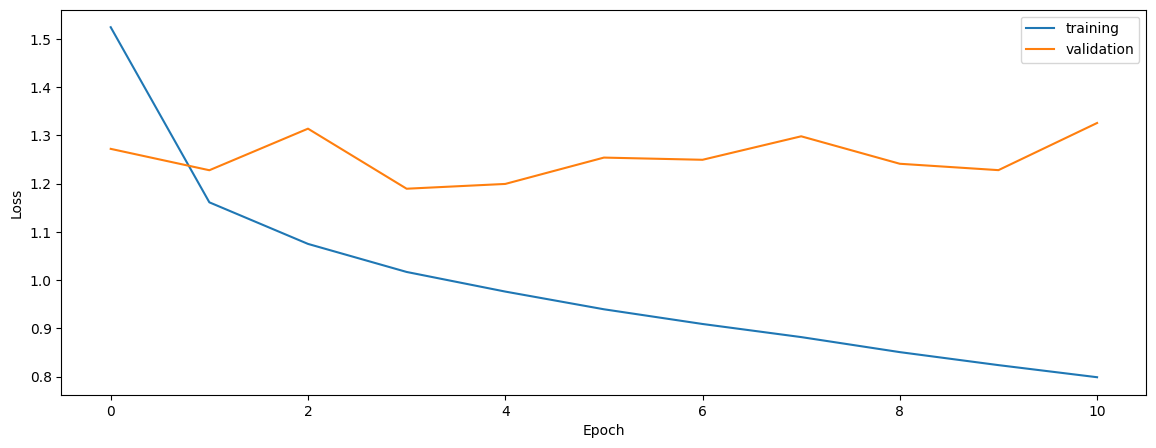

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6194278117406952
0.5302074652059351
0.5756083784023033


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5807095862272343
0.5306951672429651
0.5931324288630088


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5761539618102541
0.5352907961603613
0.5871987036661941


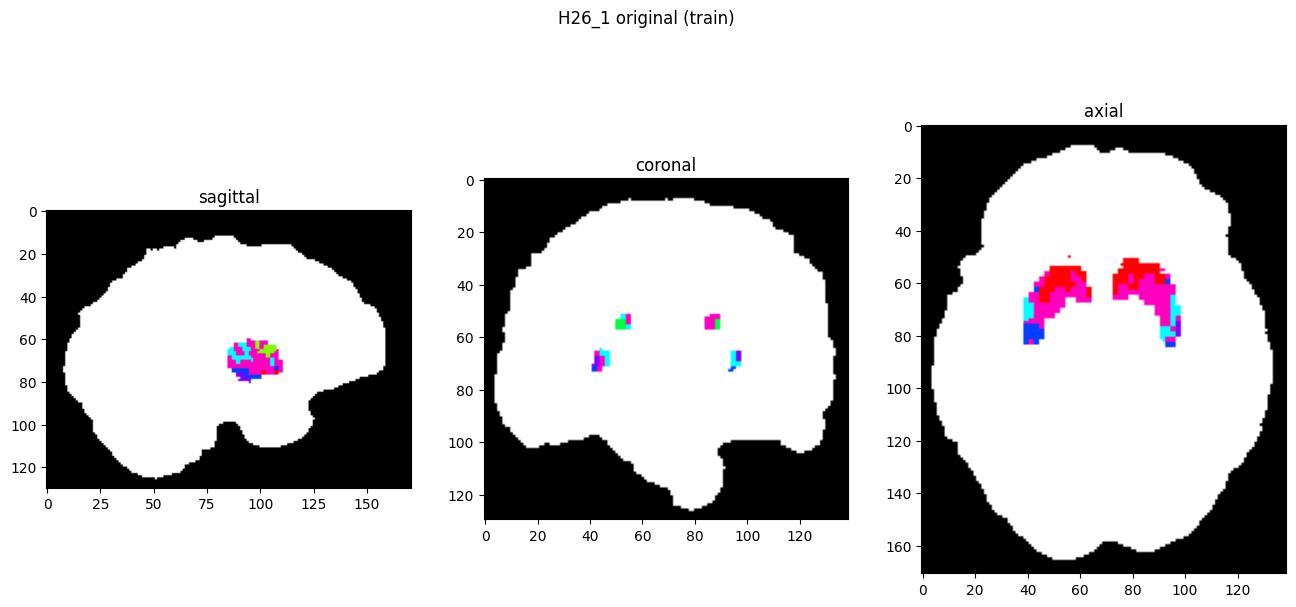

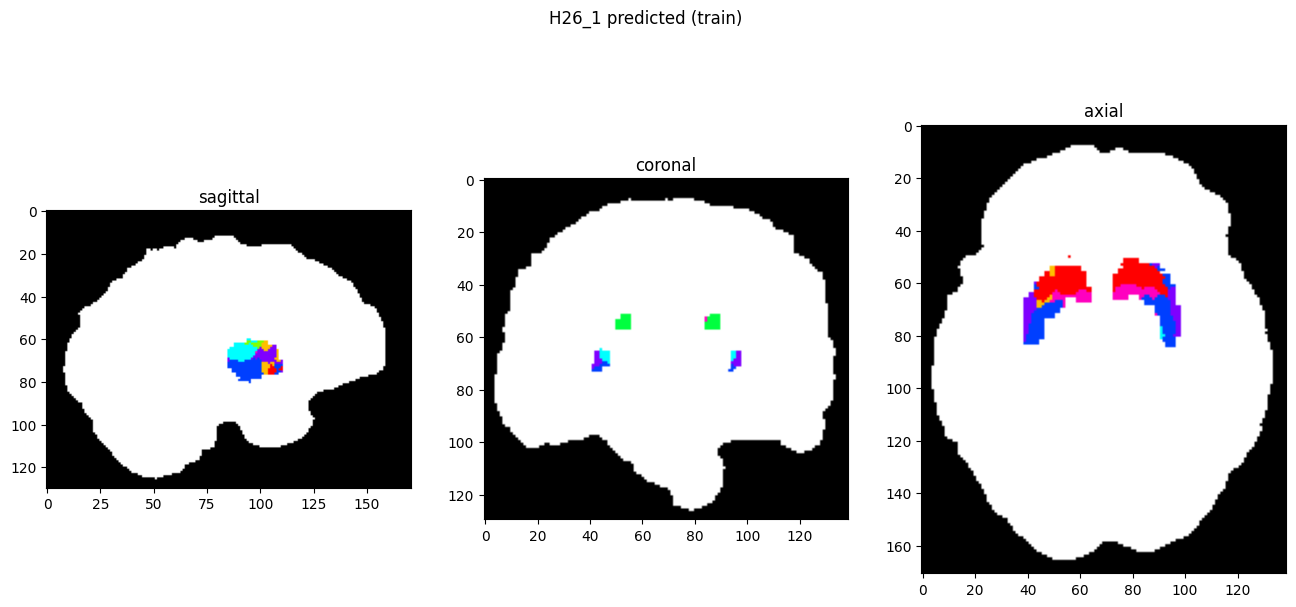

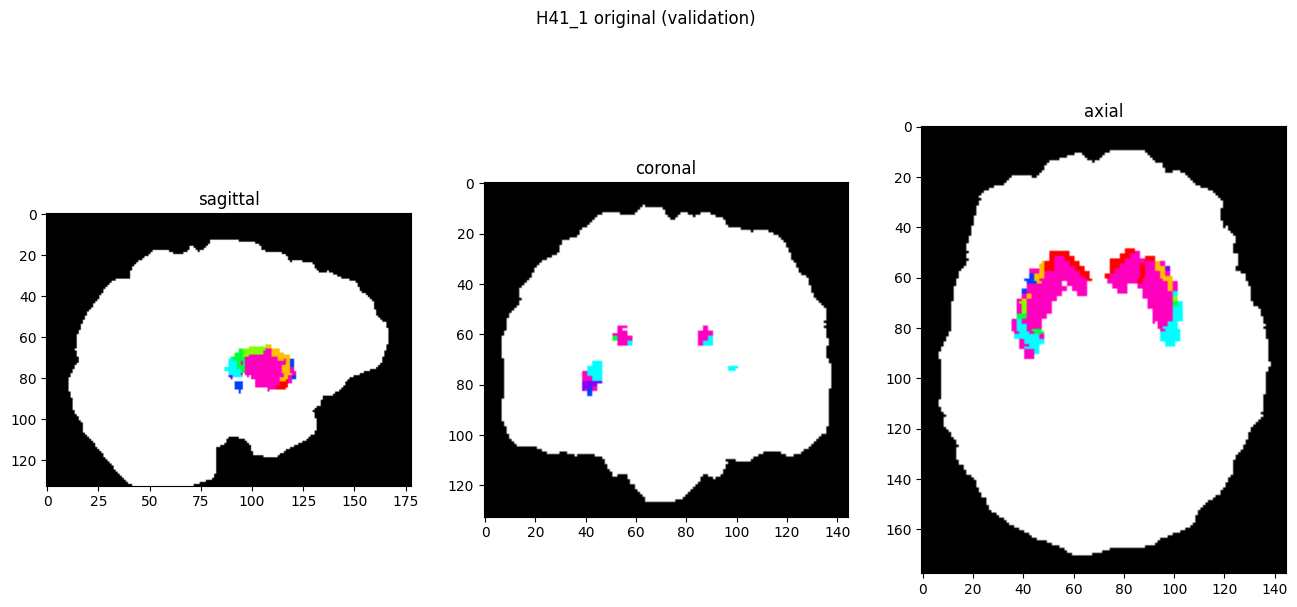

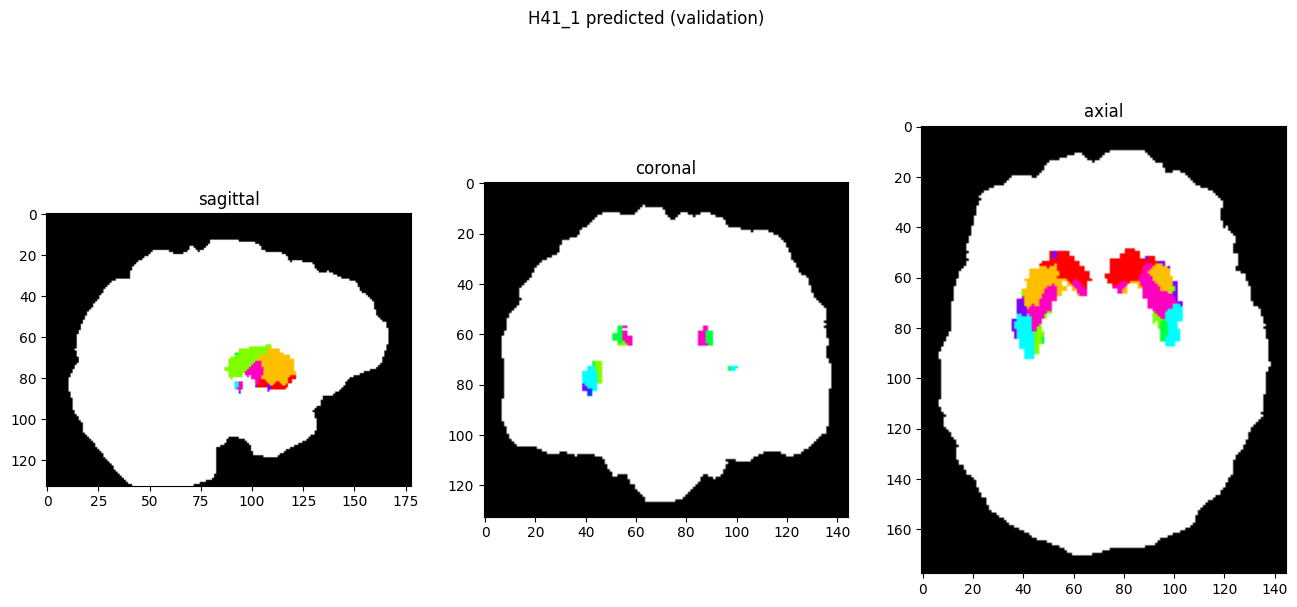

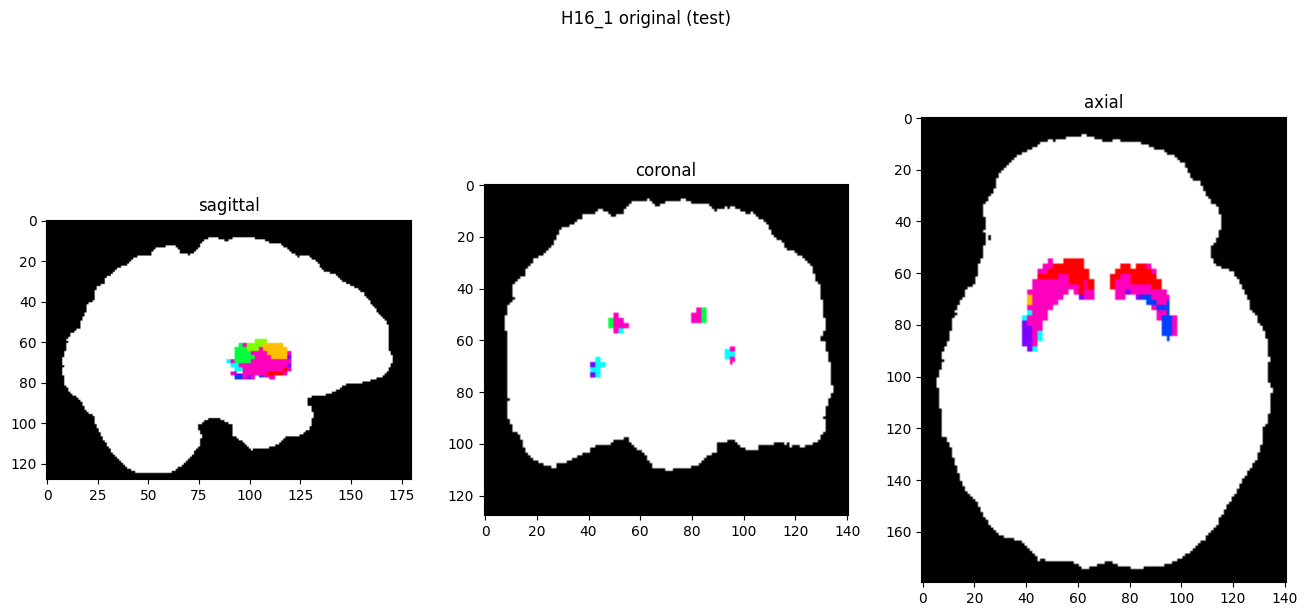

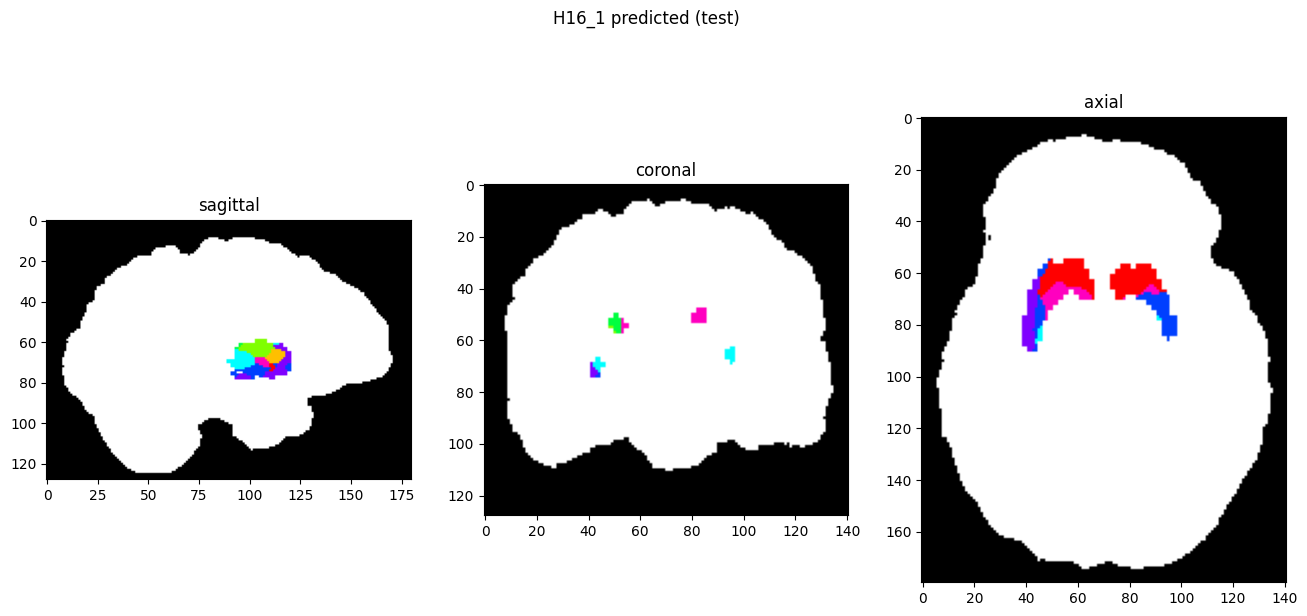

In [10]:
showResults(model, gen, threshold=0)